In [19]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv1DTranspose
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# Configure Matplotlib

Choose a matplotlib style sheet to match your browser theme (dark or light)

Increase the figure size to match the notebook width.

Set the graph colour variables.

In [2]:
#style_sheet = 'dark_background' # dark theme
#style_sheet = 'default'         # light theme
#plt.style.use(style_sheet)

plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 200

In [3]:
class BestEpoch(Callback):
  def __init__(self, metric='val_loss', mode='min'):
    super().__init__()
    self.metric = metric
    self.mode = mode
    

  def on_train_begin(self, logs={}):
    self.bestEpoch = 0
    if self.mode == 'min':
      self.bestLoss = 1e8
    else:
      self.bestLoss = -1e8

  def on_epoch_end(self, epoch, logs={}):
    valLoss = logs.get(self.metric)
    if self.mode == 'min' and valLoss < self.bestLoss:
      self.bestLoss = valLoss
      self.bestEpoch = epoch+1
    elif valLoss > self.bestLoss:
      self.bestLoss = valLoss
      self.bestEpoch = epoch+1

  def get_best_epoch(self):
    return self.bestEpoch



In [4]:
class PlotLoss(Callback):
  def __init__(self, metric='val_loss'):
    super().__init__()
    self.metric = metric
    matplotlib.interactive(True)
    
  def __del__(self):
    plt.close('all')

  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.loss_y = []
    self.metric_y = []
    self.logs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.loss_y.append(logs.get('loss'))
    self.metric_y.append(logs.get(self.metric))
    self.i += 1

    #clear_output(wait=False)
    plt.clf()
    plt.plot(self.x, self.loss_y, label="loss")
    plt.plot(self.x, self.metric_y, label=self.metric)
    plt.legend()
    plt.show(block=False);
    plt.draw();
    plt.pause(0.05)
    print(logs)


In [5]:
with open('train.dat', 'rb') as f:
    train_X = np.load(f)
    train_Y = np.load(f)

In [6]:
print(train_X.shape, train_Y.shape)

(1442, 4320, 53) (1442, 1)


In [7]:
with open('valid.dat', 'rb') as f:
    valid_X = np.load(f)
    valid_Y = np.load(f)

In [8]:
print(valid_X.shape, valid_Y.shape)

(117, 4320, 53) (117, 1)


In [9]:
#train_mean = np.mean(train_X, axis=(0,1))
#train_X[:,:] -= train_mean
#train_std = np.std(train_X, axis=(0,1))
#train_X[:,:] /= train_std
#valid_X[:,:] -= train_mean
#valid_X[:,:] /= train_std
min = np.min(train_X, axis=(0,1))
max = np.max(train_X, axis=(0,1))
train_X[:,:] = [(val - min) / (max - min) for val in train_X[:,:]]
valid_X[:,:] = [(val - min) / (max - min) for val in valid_X[:,:]]

In [10]:
with open('train.stats', 'wb') as f:
    np.save(f, min)
    np.save(f, max)

In [11]:
#nan=np.argwhere(np.isnan(train_Y))
#print(nan.shape)

In [12]:
epochs=100
batch_size=32
learning_rate=1e-3

In [13]:
model = Sequential()
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))

2023-10-09 08:42:35.515839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 08:42:35.538875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 08:42:35.539055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 08:42:35.539502: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, r

In [14]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [15]:
filepath="models/dscovrmatic-mlp-v1-e{epoch:d}"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
plotloss = PlotLoss()
bestepoch = BestEpoch()
#earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=1e-5)
#callbacks = [checkpoint, plotloss, bestepoch, earlystop]
callbacks = [checkpoint, plotloss, bestepoch]


Epoch 1/100


2023-10-09 08:42:38.018522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-09 08:42:38.045721: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x99e7990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 08:42:38.045758: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-09 08:42:38.049544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 08:42:38.143849: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/46 [============================>.] - ETA: 0s - loss: 5189.5103 - mse: 5189.5103
Epoch 1: val_loss improved from inf to 56.63770, saving model to models/dscovrmatic-mlp-v1-e1
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorf

INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e1/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e1/assets


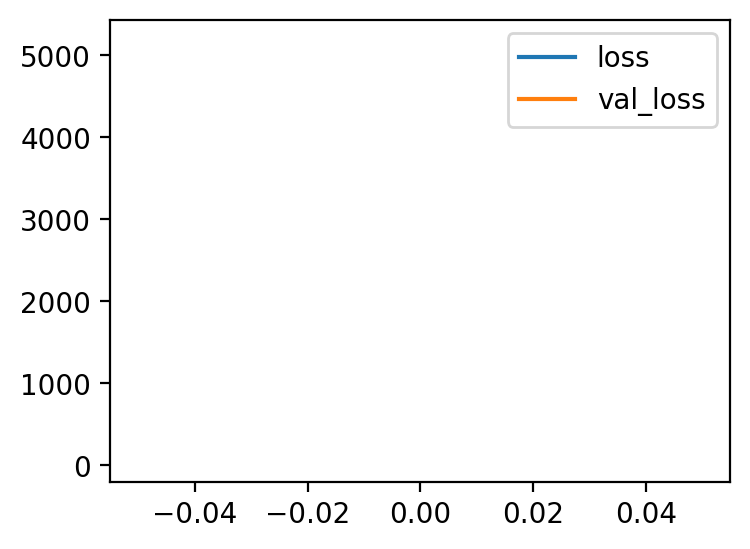

<Figure size 800x600 with 0 Axes>

{'loss': 5182.314453125, 'mse': 5182.314453125, 'val_loss': 56.63770294189453, 'val_mse': 56.63770294189453}
46/46 [==============================] - 8s 141ms/step - loss: 5182.3145 - mse: 5182.3145 - val_loss: 56.6377 - val_mse: 56.6377
Epoch 2/100
45/46 [============================>.] - ETA: 0s - loss: 12.1767 - mse: 12.1767
Epoch 2: val_loss improved from 56.63770 to 2.04928, saving model to models/dscovrmatic-mlp-v1-e2
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e2/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e2/assets


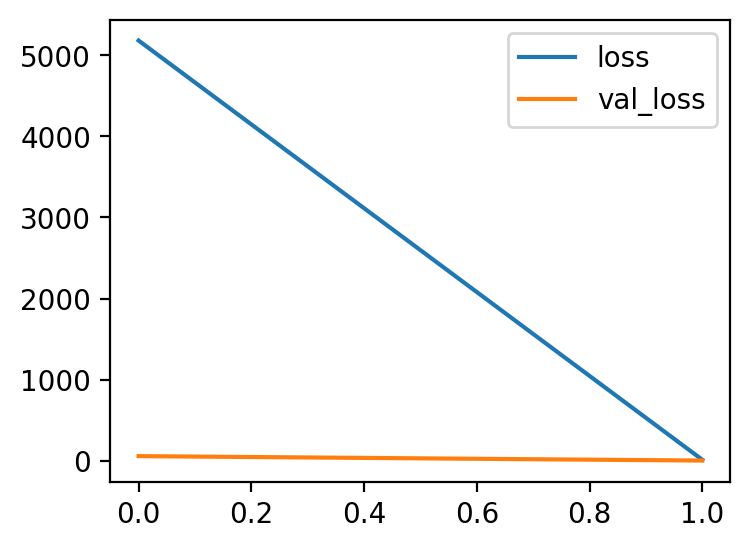

<Figure size 800x600 with 0 Axes>

{'loss': 12.166701316833496, 'mse': 12.166701316833496, 'val_loss': 2.0492806434631348, 'val_mse': 2.0492806434631348}
46/46 [==============================] - 6s 139ms/step - loss: 12.1667 - mse: 12.1667 - val_loss: 2.0493 - val_mse: 2.0493
Epoch 3/100
45/46 [============================>.] - ETA: 0s - loss: 2.4816 - mse: 2.4816
Epoch 3: val_loss improved from 2.04928 to 1.25989, saving model to models/dscovrmatic-mlp-v1-e3
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e3/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e3/assets


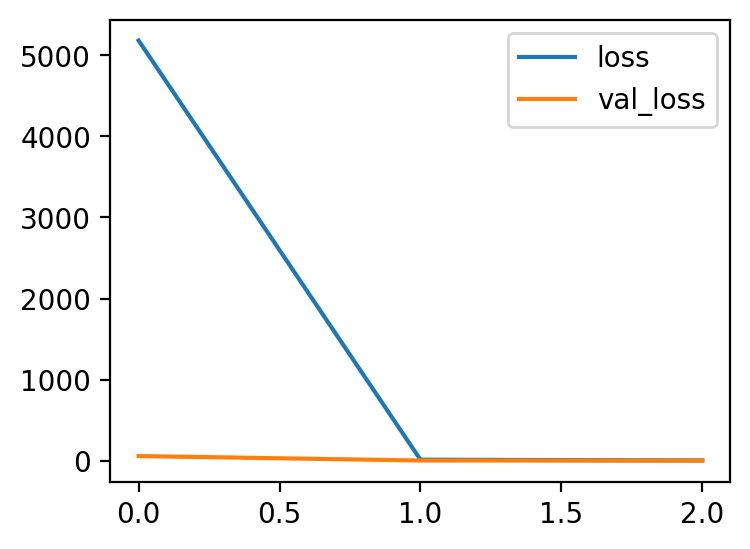

<Figure size 800x600 with 0 Axes>

{'loss': 2.47821044921875, 'mse': 2.47821044921875, 'val_loss': 1.2598868608474731, 'val_mse': 1.2598868608474731}
46/46 [==============================] - 6s 139ms/step - loss: 2.4782 - mse: 2.4782 - val_loss: 1.2599 - val_mse: 1.2599
Epoch 4/100
45/46 [============================>.] - ETA: 0s - loss: 4.8305 - mse: 4.8305
Epoch 4: val_loss did not improve from 1.25989


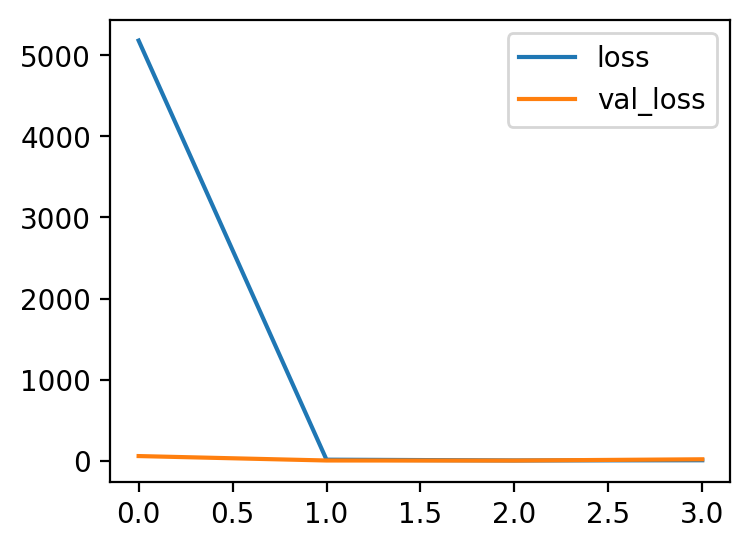

<Figure size 800x600 with 0 Axes>

{'loss': 4.827221870422363, 'mse': 4.827221870422363, 'val_loss': 16.915678024291992, 'val_mse': 16.915678024291992}
46/46 [==============================] - 1s 31ms/step - loss: 4.8272 - mse: 4.8272 - val_loss: 16.9157 - val_mse: 16.9157
Epoch 5/100
45/46 [============================>.] - ETA: 0s - loss: 11.6280 - mse: 11.6280
Epoch 5: val_loss did not improve from 1.25989


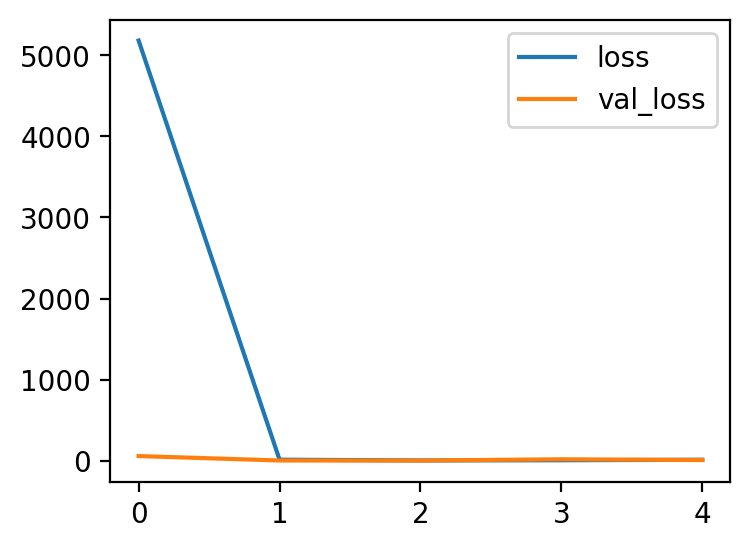

<Figure size 800x600 with 0 Axes>

{'loss': 11.616973876953125, 'mse': 11.616973876953125, 'val_loss': 7.402544021606445, 'val_mse': 7.402544021606445}
46/46 [==============================] - 1s 31ms/step - loss: 11.6170 - mse: 11.6170 - val_loss: 7.4025 - val_mse: 7.4025
Epoch 6/100
45/46 [============================>.] - ETA: 0s - loss: 6.0428 - mse: 6.0428
Epoch 6: val_loss did not improve from 1.25989


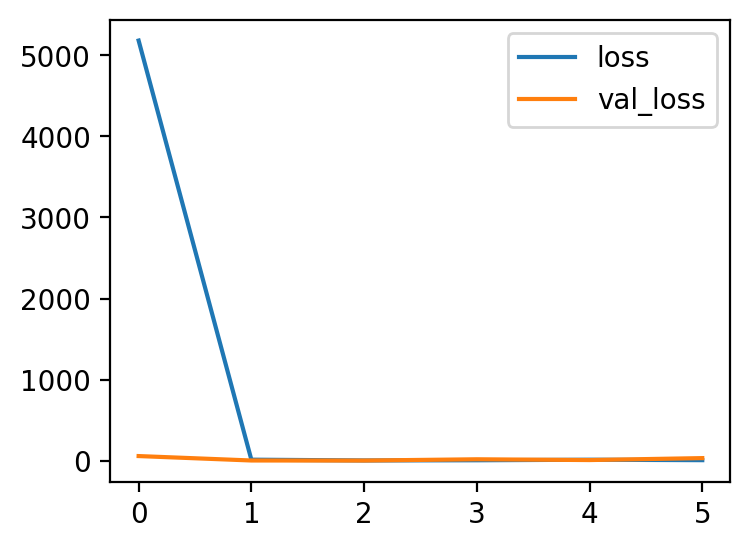

<Figure size 800x600 with 0 Axes>

{'loss': 6.036659240722656, 'mse': 6.036659240722656, 'val_loss': 31.476665496826172, 'val_mse': 31.476665496826172}
46/46 [==============================] - 1s 31ms/step - loss: 6.0367 - mse: 6.0367 - val_loss: 31.4767 - val_mse: 31.4767
Epoch 7/100
45/46 [============================>.] - ETA: 0s - loss: 5.2879 - mse: 5.2879
Epoch 7: val_loss did not improve from 1.25989


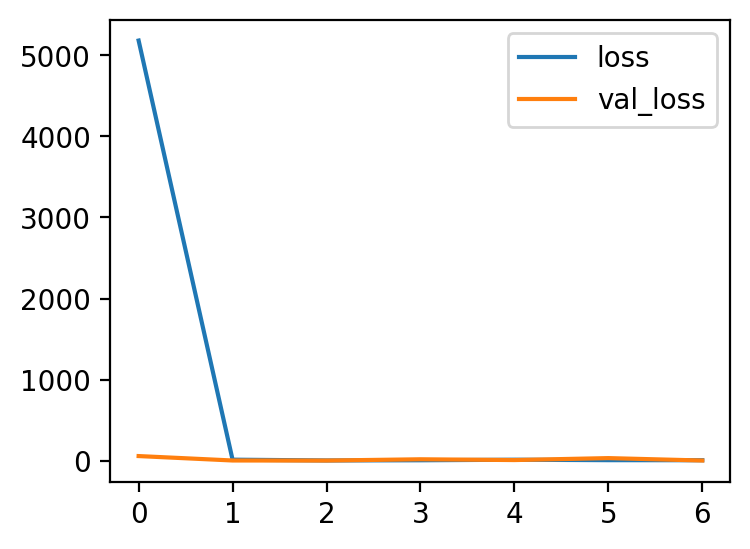

<Figure size 800x600 with 0 Axes>

{'loss': 5.286664962768555, 'mse': 5.286664962768555, 'val_loss': 1.7293744087219238, 'val_mse': 1.7293745279312134}
46/46 [==============================] - 1s 31ms/step - loss: 5.2867 - mse: 5.2867 - val_loss: 1.7294 - val_mse: 1.7294
Epoch 8/100
45/46 [============================>.] - ETA: 0s - loss: 4.3705 - mse: 4.3705
Epoch 8: val_loss did not improve from 1.25989


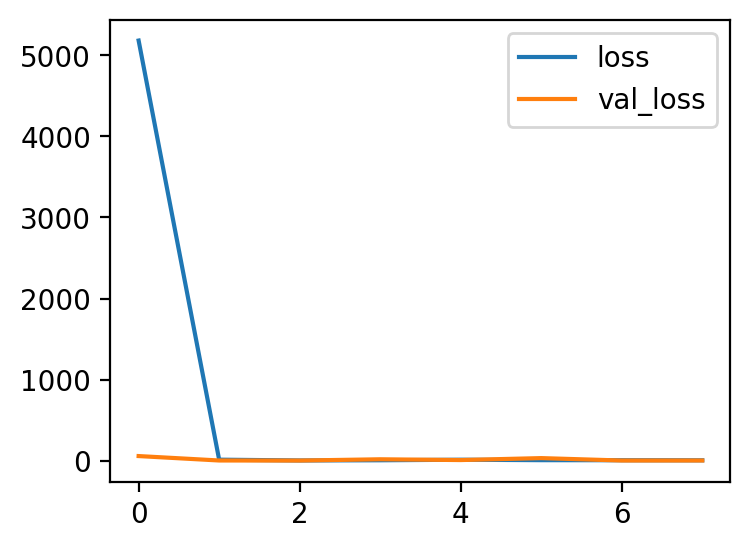

<Figure size 800x600 with 0 Axes>

{'loss': 4.37920618057251, 'mse': 4.37920618057251, 'val_loss': 2.004441976547241, 'val_mse': 2.004441976547241}
46/46 [==============================] - 1s 31ms/step - loss: 4.3792 - mse: 4.3792 - val_loss: 2.0044 - val_mse: 2.0044
Epoch 9/100
45/46 [============================>.] - ETA: 0s - loss: 7.0336 - mse: 7.0336
Epoch 9: val_loss did not improve from 1.25989


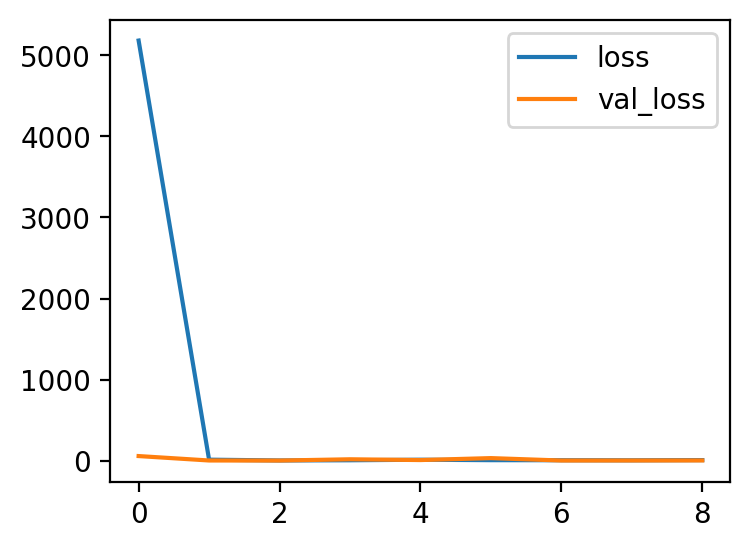

<Figure size 800x600 with 0 Axes>

{'loss': 7.028573036193848, 'mse': 7.028573036193848, 'val_loss': 2.716426372528076, 'val_mse': 2.716426372528076}
46/46 [==============================] - 1s 31ms/step - loss: 7.0286 - mse: 7.0286 - val_loss: 2.7164 - val_mse: 2.7164
Epoch 10/100
45/46 [============================>.] - ETA: 0s - loss: 1.7082 - mse: 1.7082
Epoch 10: val_loss did not improve from 1.25989


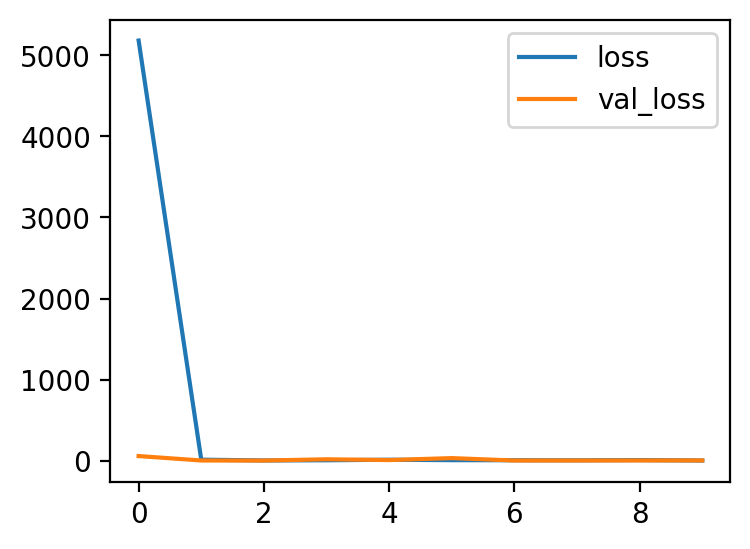

<Figure size 800x600 with 0 Axes>

{'loss': 1.7079691886901855, 'mse': 1.7079691886901855, 'val_loss': 2.8325676918029785, 'val_mse': 2.8325676918029785}
46/46 [==============================] - 1s 31ms/step - loss: 1.7080 - mse: 1.7080 - val_loss: 2.8326 - val_mse: 2.8326
Epoch 11/100
45/46 [============================>.] - ETA: 0s - loss: 2.4130 - mse: 2.4130
Epoch 11: val_loss did not improve from 1.25989


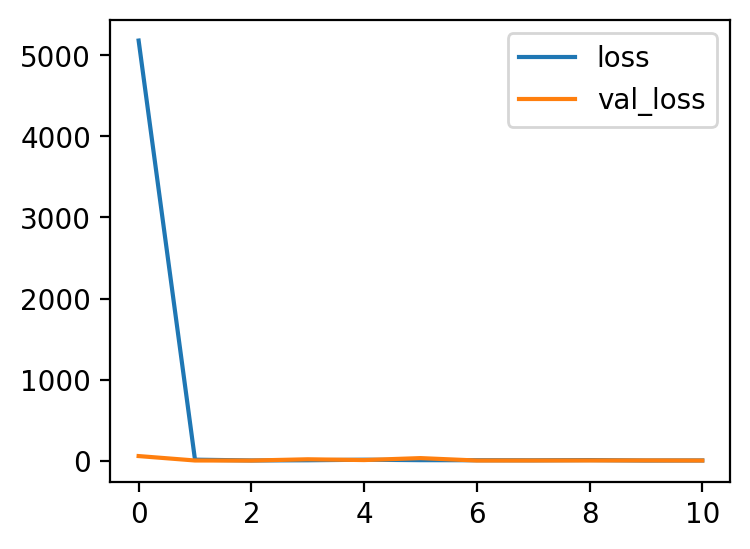

<Figure size 800x600 with 0 Axes>

{'loss': 2.411269187927246, 'mse': 2.411269187927246, 'val_loss': 1.6156619787216187, 'val_mse': 1.6156619787216187}
46/46 [==============================] - 1s 31ms/step - loss: 2.4113 - mse: 2.4113 - val_loss: 1.6157 - val_mse: 1.6157
Epoch 12/100
45/46 [============================>.] - ETA: 0s - loss: 1.1647 - mse: 1.1647
Epoch 12: val_loss did not improve from 1.25989


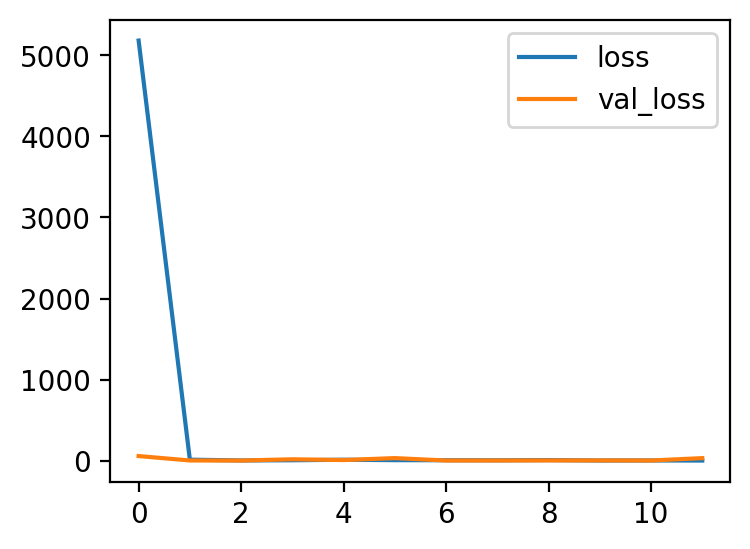

<Figure size 800x600 with 0 Axes>

{'loss': 1.1733828783035278, 'mse': 1.1733828783035278, 'val_loss': 31.2287654876709, 'val_mse': 31.2287654876709}
46/46 [==============================] - 1s 31ms/step - loss: 1.1734 - mse: 1.1734 - val_loss: 31.2288 - val_mse: 31.2288
Epoch 13/100
45/46 [============================>.] - ETA: 0s - loss: 4.7761 - mse: 4.7761
Epoch 13: val_loss did not improve from 1.25989


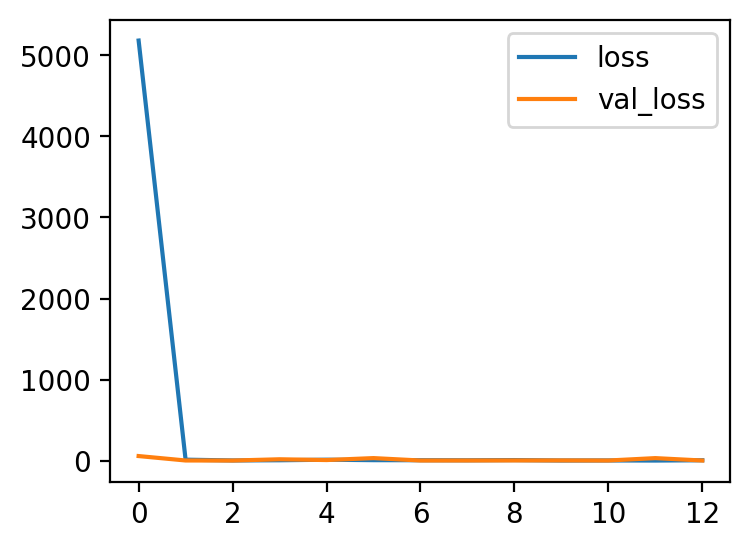

<Figure size 800x600 with 0 Axes>

{'loss': 4.77248477935791, 'mse': 4.77248477935791, 'val_loss': 1.642685055732727, 'val_mse': 1.642685055732727}
46/46 [==============================] - 1s 31ms/step - loss: 4.7725 - mse: 4.7725 - val_loss: 1.6427 - val_mse: 1.6427
Epoch 14/100
45/46 [============================>.] - ETA: 0s - loss: 1.3026 - mse: 1.3026
Epoch 14: val_loss did not improve from 1.25989


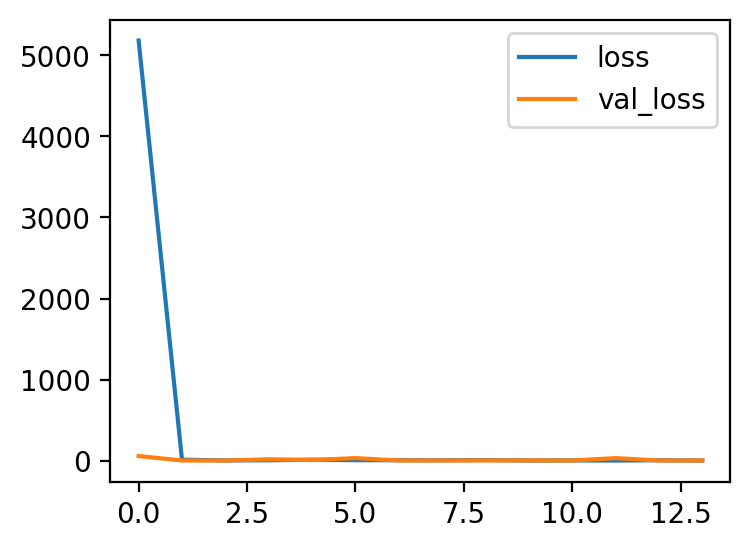

<Figure size 800x600 with 0 Axes>

{'loss': 1.3027448654174805, 'mse': 1.3027448654174805, 'val_loss': 1.8678407669067383, 'val_mse': 1.8678407669067383}
46/46 [==============================] - 1s 31ms/step - loss: 1.3027 - mse: 1.3027 - val_loss: 1.8678 - val_mse: 1.8678
Epoch 15/100
45/46 [============================>.] - ETA: 0s - loss: 1.2026 - mse: 1.2026
Epoch 15: val_loss did not improve from 1.25989


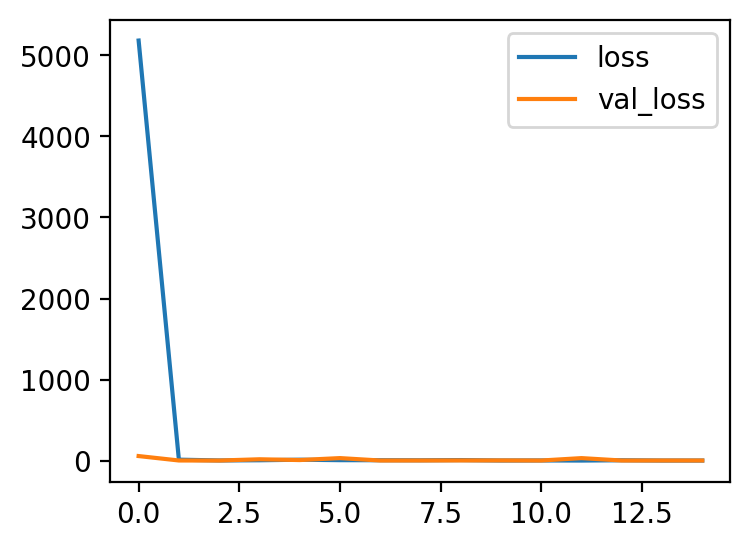

<Figure size 800x600 with 0 Axes>

{'loss': 1.2011535167694092, 'mse': 1.2011535167694092, 'val_loss': 1.7293349504470825, 'val_mse': 1.7293349504470825}
46/46 [==============================] - 1s 31ms/step - loss: 1.2012 - mse: 1.2012 - val_loss: 1.7293 - val_mse: 1.7293
Epoch 16/100
45/46 [============================>.] - ETA: 0s - loss: 1.1092 - mse: 1.1092
Epoch 16: val_loss did not improve from 1.25989


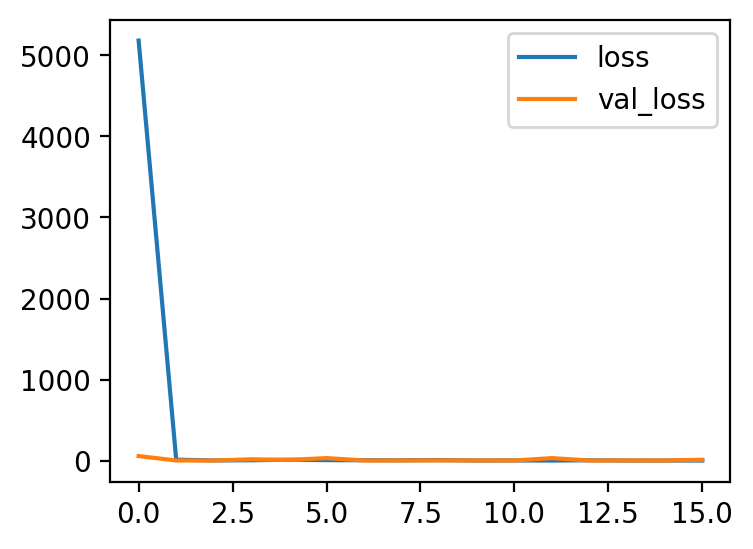

<Figure size 800x600 with 0 Axes>

{'loss': 1.1078670024871826, 'mse': 1.1078670024871826, 'val_loss': 10.509807586669922, 'val_mse': 10.509807586669922}
46/46 [==============================] - 1s 31ms/step - loss: 1.1079 - mse: 1.1079 - val_loss: 10.5098 - val_mse: 10.5098
Epoch 17/100
45/46 [============================>.] - ETA: 0s - loss: 7.0527 - mse: 7.0527
Epoch 17: val_loss did not improve from 1.25989


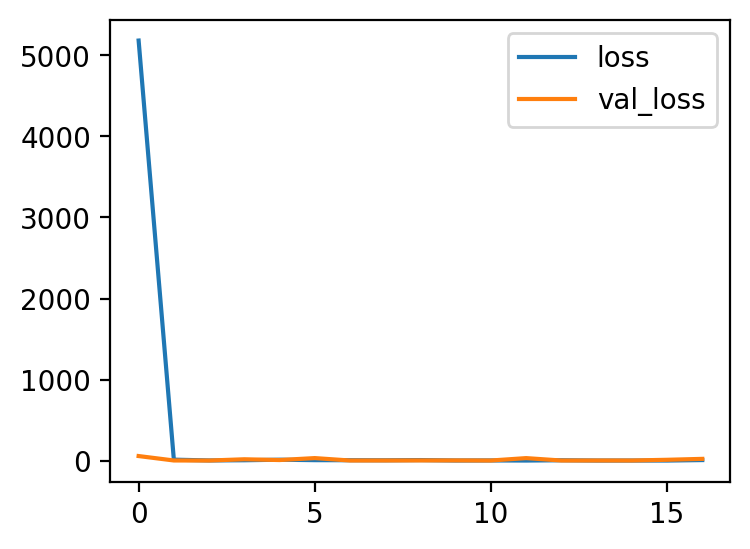

<Figure size 800x600 with 0 Axes>

{'loss': 7.0508856773376465, 'mse': 7.0508856773376465, 'val_loss': 21.91744041442871, 'val_mse': 21.91744041442871}
46/46 [==============================] - 1s 31ms/step - loss: 7.0509 - mse: 7.0509 - val_loss: 21.9174 - val_mse: 21.9174
Epoch 18/100
45/46 [============================>.] - ETA: 0s - loss: 3.0824 - mse: 3.0824
Epoch 18: val_loss did not improve from 1.25989


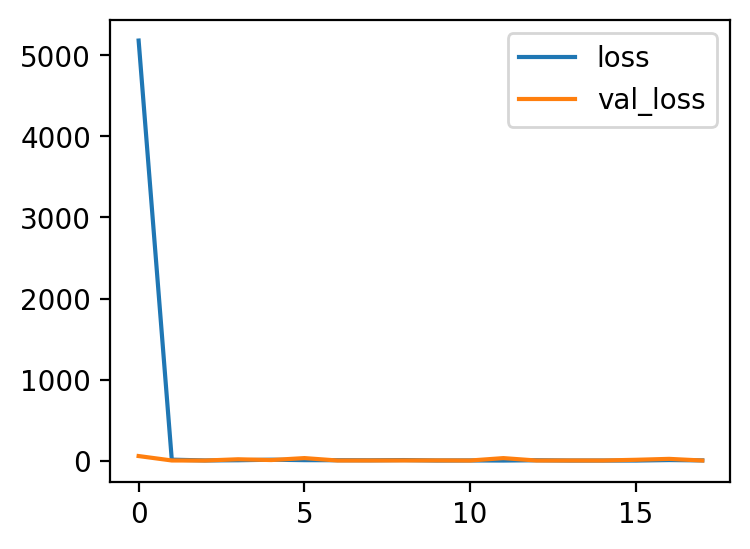

<Figure size 800x600 with 0 Axes>

{'loss': 3.0791304111480713, 'mse': 3.0791304111480713, 'val_loss': 1.6976187229156494, 'val_mse': 1.6976187229156494}
46/46 [==============================] - 1s 31ms/step - loss: 3.0791 - mse: 3.0791 - val_loss: 1.6976 - val_mse: 1.6976
Epoch 19/100
45/46 [============================>.] - ETA: 0s - loss: 1.1948 - mse: 1.1948
Epoch 19: val_loss did not improve from 1.25989


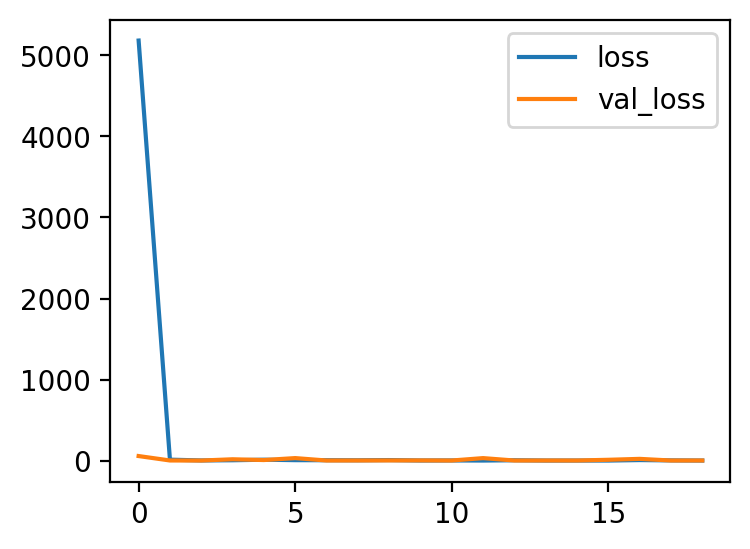

<Figure size 800x600 with 0 Axes>

{'loss': 1.1943424940109253, 'mse': 1.1943424940109253, 'val_loss': 1.8968088626861572, 'val_mse': 1.8968088626861572}
46/46 [==============================] - 1s 31ms/step - loss: 1.1943 - mse: 1.1943 - val_loss: 1.8968 - val_mse: 1.8968
Epoch 20/100
45/46 [============================>.] - ETA: 0s - loss: 1.5460 - mse: 1.5460
Epoch 20: val_loss did not improve from 1.25989


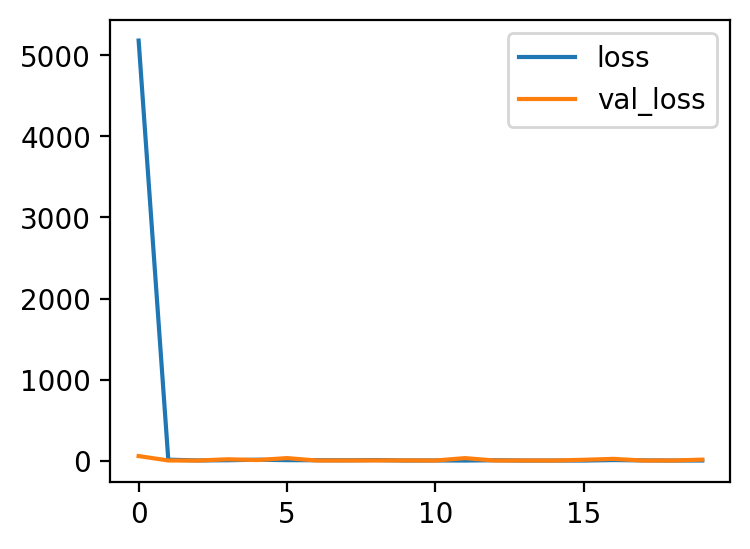

<Figure size 800x600 with 0 Axes>

{'loss': 1.5448514223098755, 'mse': 1.5448514223098755, 'val_loss': 12.533746719360352, 'val_mse': 12.533746719360352}
46/46 [==============================] - 1s 31ms/step - loss: 1.5449 - mse: 1.5449 - val_loss: 12.5337 - val_mse: 12.5337
Epoch 21/100
45/46 [============================>.] - ETA: 0s - loss: 2.7667 - mse: 2.7667
Epoch 21: val_loss improved from 1.25989 to 1.25160, saving model to models/dscovrmatic-mlp-v1-e21
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e21/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e21/assets


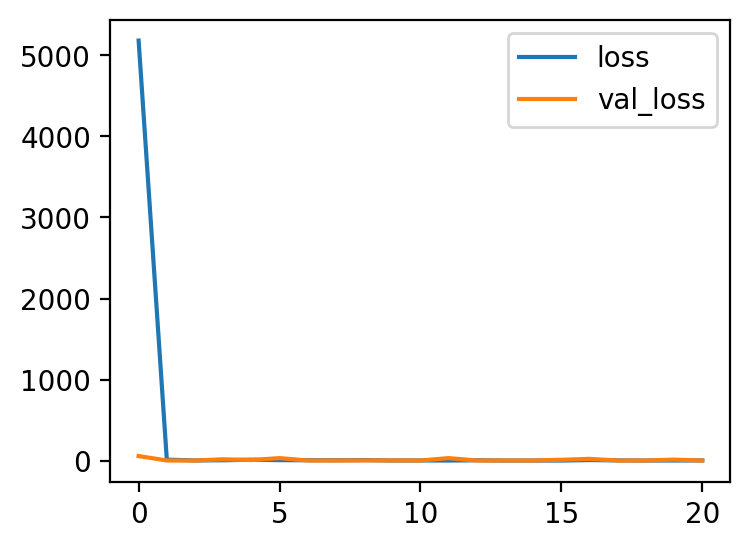

<Figure size 800x600 with 0 Axes>

{'loss': 2.764711856842041, 'mse': 2.764711856842041, 'val_loss': 1.2515960931777954, 'val_mse': 1.2515960931777954}
46/46 [==============================] - 6s 134ms/step - loss: 2.7647 - mse: 2.7647 - val_loss: 1.2516 - val_mse: 1.2516
Epoch 22/100
45/46 [============================>.] - ETA: 0s - loss: 0.9416 - mse: 0.9416
Epoch 22: val_loss did not improve from 1.25160


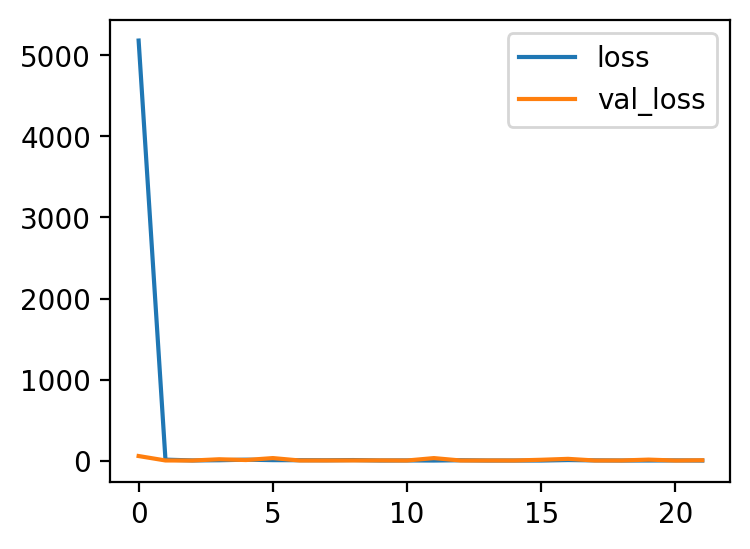

<Figure size 800x600 with 0 Axes>

{'loss': 0.9403950572013855, 'mse': 0.9403950572013855, 'val_loss': 4.793018817901611, 'val_mse': 4.793018817901611}
46/46 [==============================] - 1s 31ms/step - loss: 0.9404 - mse: 0.9404 - val_loss: 4.7930 - val_mse: 4.7930
Epoch 23/100
45/46 [============================>.] - ETA: 0s - loss: 1.3892 - mse: 1.3892
Epoch 23: val_loss improved from 1.25160 to 1.17520, saving model to models/dscovrmatic-mlp-v1-e23
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e23/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e23/assets


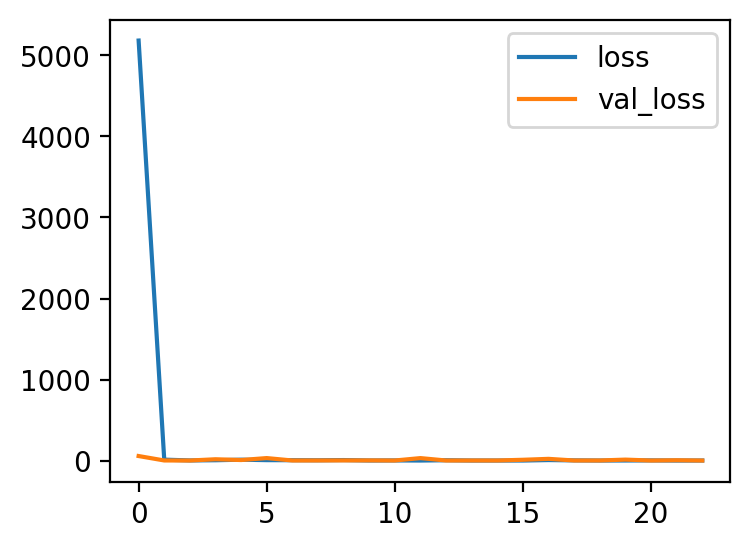

<Figure size 800x600 with 0 Axes>

{'loss': 1.3880698680877686, 'mse': 1.3880698680877686, 'val_loss': 1.175201654434204, 'val_mse': 1.175201654434204}
46/46 [==============================] - 6s 136ms/step - loss: 1.3881 - mse: 1.3881 - val_loss: 1.1752 - val_mse: 1.1752
Epoch 24/100
45/46 [============================>.] - ETA: 0s - loss: 1.2647 - mse: 1.2647
Epoch 24: val_loss did not improve from 1.17520


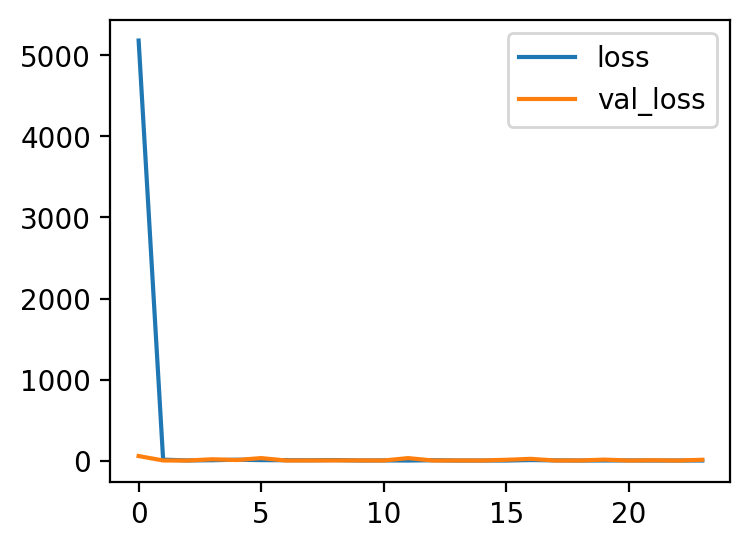

<Figure size 800x600 with 0 Axes>

{'loss': 1.2637547254562378, 'mse': 1.2637547254562378, 'val_loss': 10.65829086303711, 'val_mse': 10.65829086303711}
46/46 [==============================] - 1s 31ms/step - loss: 1.2638 - mse: 1.2638 - val_loss: 10.6583 - val_mse: 10.6583
Epoch 25/100
45/46 [============================>.] - ETA: 0s - loss: 2.7354 - mse: 2.7354
Epoch 25: val_loss did not improve from 1.17520


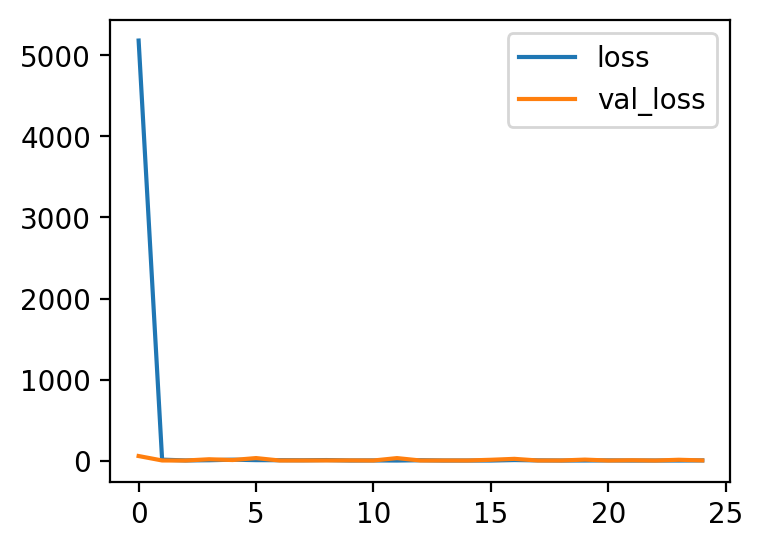

<Figure size 800x600 with 0 Axes>

{'loss': 2.732837438583374, 'mse': 2.732837438583374, 'val_loss': 2.631150484085083, 'val_mse': 2.631150484085083}
46/46 [==============================] - 1s 32ms/step - loss: 2.7328 - mse: 2.7328 - val_loss: 2.6312 - val_mse: 2.6312
Epoch 26/100
45/46 [============================>.] - ETA: 0s - loss: 1.0684 - mse: 1.0684
Epoch 26: val_loss did not improve from 1.17520


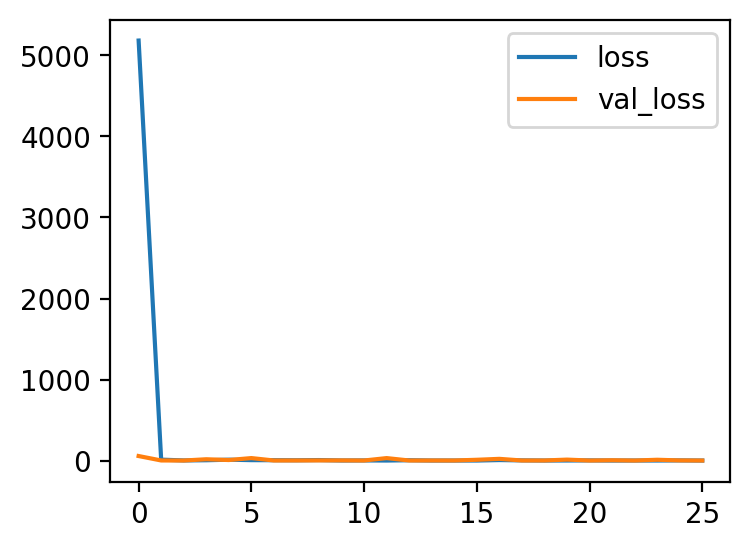

<Figure size 800x600 with 0 Axes>

{'loss': 1.0702401399612427, 'mse': 1.0702401399612427, 'val_loss': 1.182356595993042, 'val_mse': 1.182356595993042}
46/46 [==============================] - 1s 32ms/step - loss: 1.0702 - mse: 1.0702 - val_loss: 1.1824 - val_mse: 1.1824
Epoch 27/100
45/46 [============================>.] - ETA: 0s - loss: 0.9687 - mse: 0.9687
Epoch 27: val_loss did not improve from 1.17520


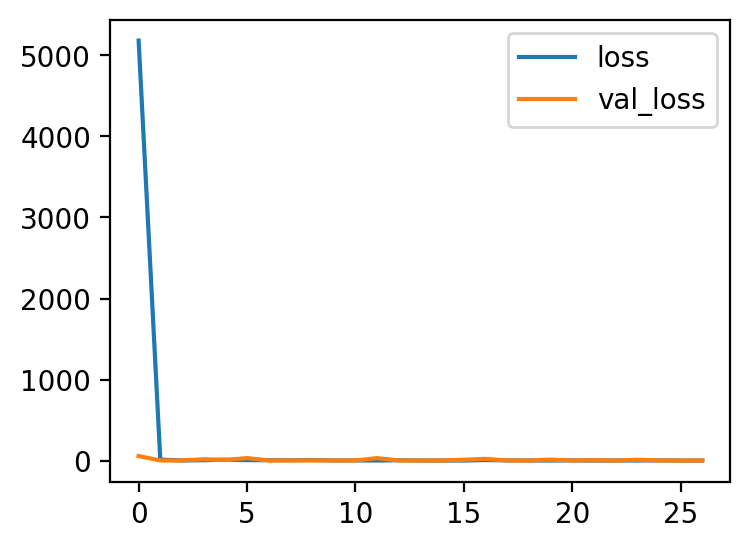

<Figure size 800x600 with 0 Axes>

{'loss': 0.9698647260665894, 'mse': 0.9698647260665894, 'val_loss': 2.1849894523620605, 'val_mse': 2.1849894523620605}
46/46 [==============================] - 1s 31ms/step - loss: 0.9699 - mse: 0.9699 - val_loss: 2.1850 - val_mse: 2.1850
Epoch 28/100
45/46 [============================>.] - ETA: 0s - loss: 0.9447 - mse: 0.9447
Epoch 28: val_loss did not improve from 1.17520


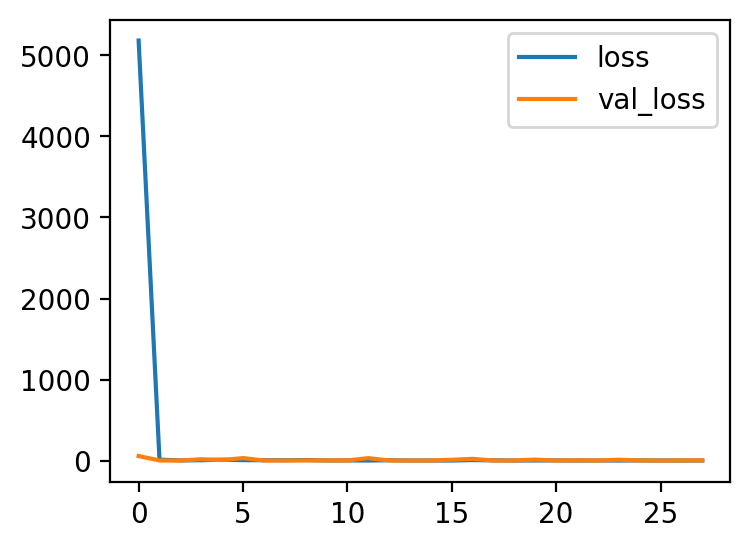

<Figure size 800x600 with 0 Axes>

{'loss': 0.9439458250999451, 'mse': 0.9439458250999451, 'val_loss': 3.657074213027954, 'val_mse': 3.657074213027954}
46/46 [==============================] - 1s 31ms/step - loss: 0.9439 - mse: 0.9439 - val_loss: 3.6571 - val_mse: 3.6571
Epoch 29/100
45/46 [============================>.] - ETA: 0s - loss: 1.7615 - mse: 1.7615
Epoch 29: val_loss did not improve from 1.17520


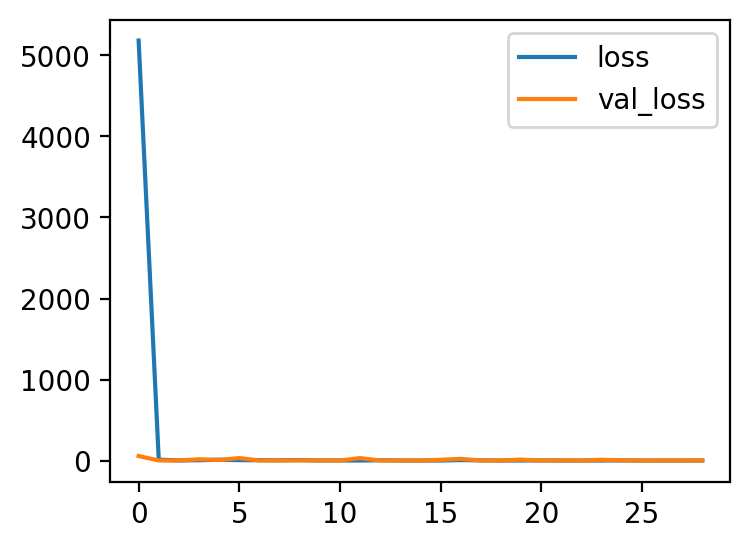

<Figure size 800x600 with 0 Axes>

{'loss': 1.7601944208145142, 'mse': 1.7601944208145142, 'val_loss': 1.546372652053833, 'val_mse': 1.546372652053833}
46/46 [==============================] - 1s 31ms/step - loss: 1.7602 - mse: 1.7602 - val_loss: 1.5464 - val_mse: 1.5464
Epoch 30/100
45/46 [============================>.] - ETA: 0s - loss: 1.1727 - mse: 1.1727
Epoch 30: val_loss did not improve from 1.17520


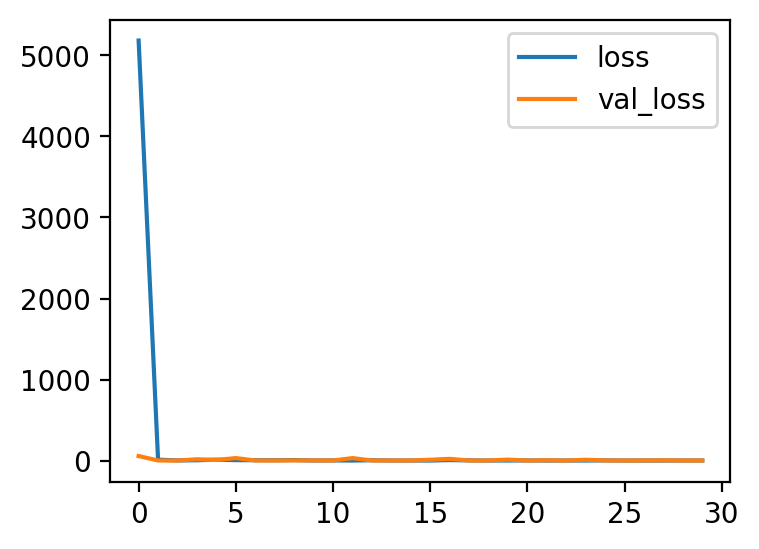

<Figure size 800x600 with 0 Axes>

{'loss': 1.17256498336792, 'mse': 1.17256498336792, 'val_loss': 1.5506025552749634, 'val_mse': 1.5506025552749634}
46/46 [==============================] - 1s 31ms/step - loss: 1.1726 - mse: 1.1726 - val_loss: 1.5506 - val_mse: 1.5506
Epoch 31/100
45/46 [============================>.] - ETA: 0s - loss: 1.4134 - mse: 1.4134
Epoch 31: val_loss did not improve from 1.17520


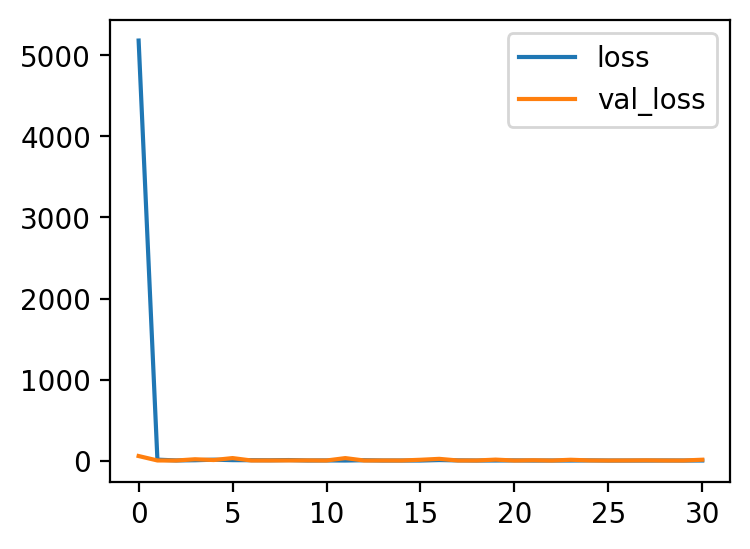

<Figure size 800x600 with 0 Axes>

{'loss': 1.4117790460586548, 'mse': 1.4117790460586548, 'val_loss': 11.253669738769531, 'val_mse': 11.253669738769531}
46/46 [==============================] - 1s 31ms/step - loss: 1.4118 - mse: 1.4118 - val_loss: 11.2537 - val_mse: 11.2537
Epoch 32/100
45/46 [============================>.] - ETA: 0s - loss: 1.9518 - mse: 1.9518
Epoch 32: val_loss did not improve from 1.17520


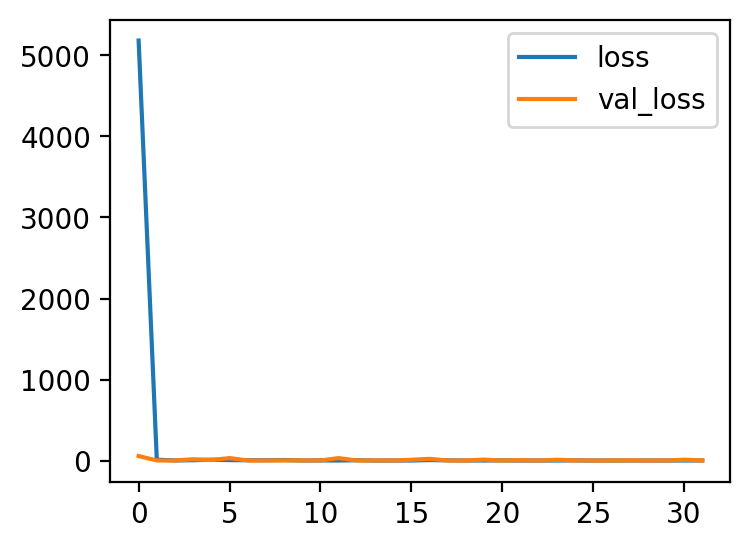

<Figure size 800x600 with 0 Axes>

{'loss': 1.9512791633605957, 'mse': 1.9512791633605957, 'val_loss': 2.3873374462127686, 'val_mse': 2.3873374462127686}
46/46 [==============================] - 1s 31ms/step - loss: 1.9513 - mse: 1.9513 - val_loss: 2.3873 - val_mse: 2.3873
Epoch 33/100
45/46 [============================>.] - ETA: 0s - loss: 1.0025 - mse: 1.0025
Epoch 33: val_loss did not improve from 1.17520


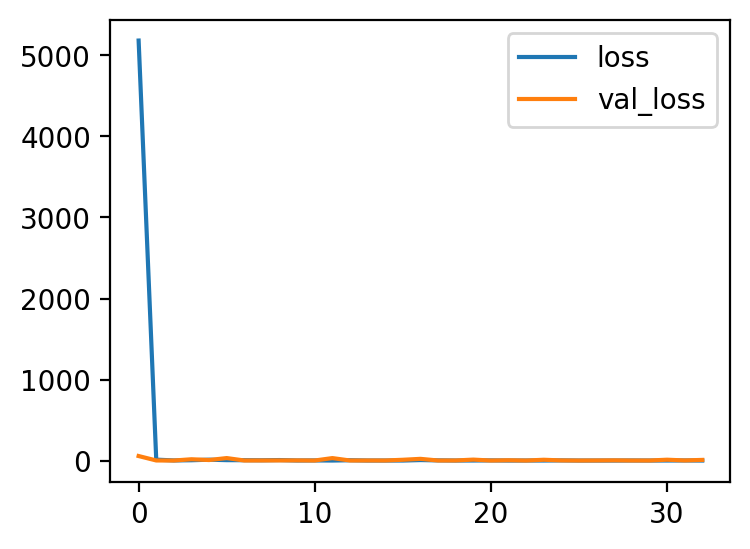

<Figure size 800x600 with 0 Axes>

{'loss': 1.0044001340866089, 'mse': 1.0044001340866089, 'val_loss': 8.921310424804688, 'val_mse': 8.921310424804688}
46/46 [==============================] - 1s 31ms/step - loss: 1.0044 - mse: 1.0044 - val_loss: 8.9213 - val_mse: 8.9213
Epoch 34/100
45/46 [============================>.] - ETA: 0s - loss: 1.5246 - mse: 1.5246
Epoch 34: val_loss did not improve from 1.17520


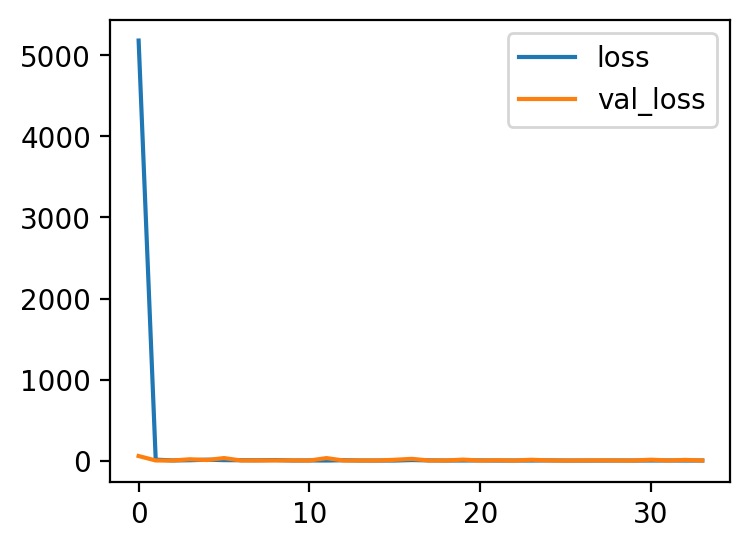

<Figure size 800x600 with 0 Axes>

{'loss': 1.522606372833252, 'mse': 1.522606372833252, 'val_loss': 1.852681040763855, 'val_mse': 1.852681040763855}
46/46 [==============================] - 2s 34ms/step - loss: 1.5226 - mse: 1.5226 - val_loss: 1.8527 - val_mse: 1.8527
Epoch 35/100
45/46 [============================>.] - ETA: 0s - loss: 1.4296 - mse: 1.4296
Epoch 35: val_loss did not improve from 1.17520


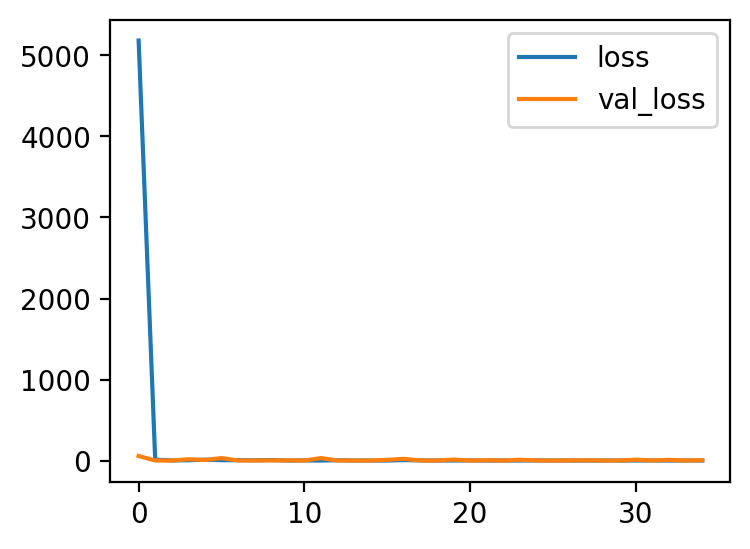

<Figure size 800x600 with 0 Axes>

{'loss': 1.4295421838760376, 'mse': 1.4295421838760376, 'val_loss': 5.149509906768799, 'val_mse': 5.149509906768799}
46/46 [==============================] - 1s 32ms/step - loss: 1.4295 - mse: 1.4295 - val_loss: 5.1495 - val_mse: 5.1495
Epoch 36/100
45/46 [============================>.] - ETA: 0s - loss: 1.3883 - mse: 1.3883
Epoch 36: val_loss improved from 1.17520 to 1.15774, saving model to models/dscovrmatic-mlp-v1-e36
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e36/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e36/assets


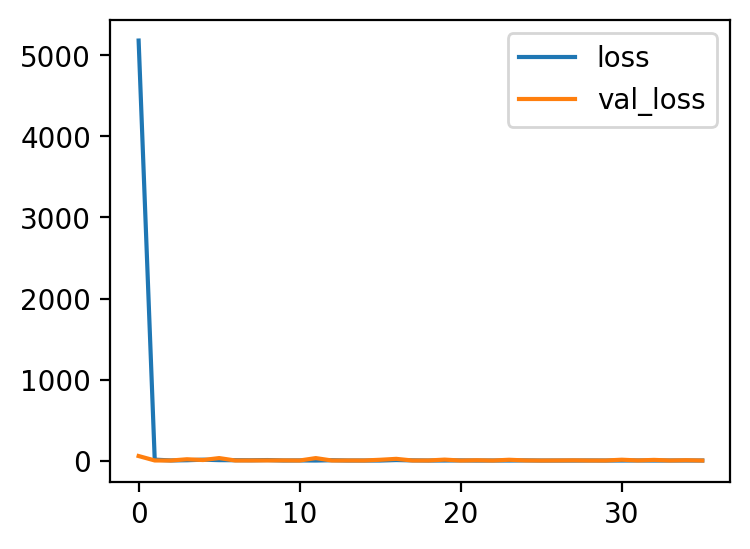

<Figure size 800x600 with 0 Axes>

{'loss': 1.3876839876174927, 'mse': 1.3876839876174927, 'val_loss': 1.1577361822128296, 'val_mse': 1.1577361822128296}
46/46 [==============================] - 6s 134ms/step - loss: 1.3877 - mse: 1.3877 - val_loss: 1.1577 - val_mse: 1.1577
Epoch 37/100
45/46 [============================>.] - ETA: 0s - loss: 1.1499 - mse: 1.1499
Epoch 37: val_loss did not improve from 1.15774


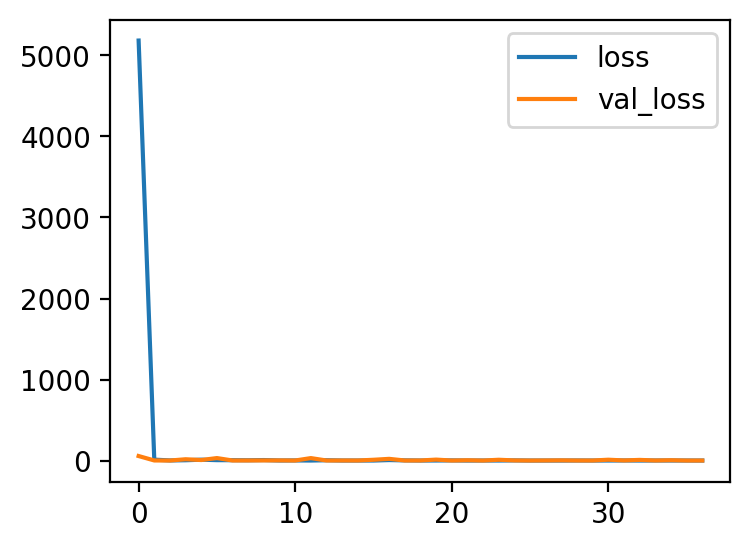

<Figure size 800x600 with 0 Axes>

{'loss': 1.1504848003387451, 'mse': 1.1504848003387451, 'val_loss': 1.2805100679397583, 'val_mse': 1.2805100679397583}
46/46 [==============================] - 1s 31ms/step - loss: 1.1505 - mse: 1.1505 - val_loss: 1.2805 - val_mse: 1.2805
Epoch 38/100
45/46 [============================>.] - ETA: 0s - loss: 1.8475 - mse: 1.8475
Epoch 38: val_loss did not improve from 1.15774


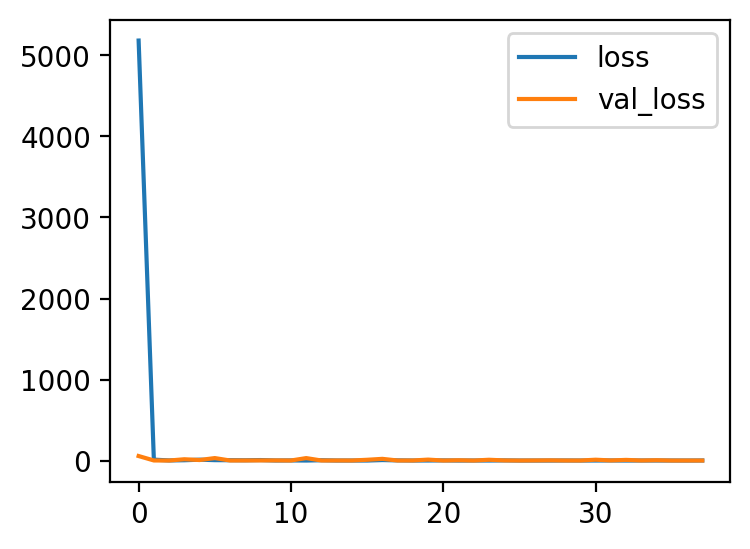

<Figure size 800x600 with 0 Axes>

{'loss': 1.84953773021698, 'mse': 1.84953773021698, 'val_loss': 1.267148494720459, 'val_mse': 1.267148494720459}
46/46 [==============================] - 1s 31ms/step - loss: 1.8495 - mse: 1.8495 - val_loss: 1.2671 - val_mse: 1.2671
Epoch 39/100
45/46 [============================>.] - ETA: 0s - loss: 1.6534 - mse: 1.6534
Epoch 39: val_loss did not improve from 1.15774


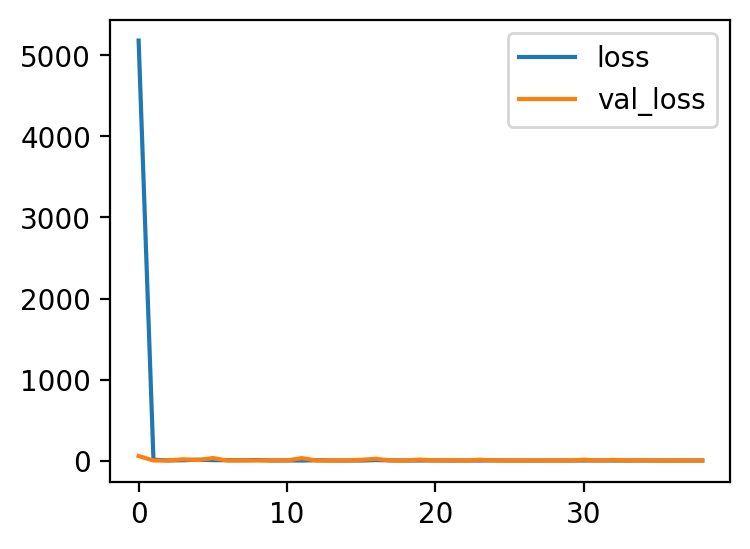

<Figure size 800x600 with 0 Axes>

{'loss': 1.6516273021697998, 'mse': 1.6516273021697998, 'val_loss': 1.188133955001831, 'val_mse': 1.188133955001831}
46/46 [==============================] - 1s 31ms/step - loss: 1.6516 - mse: 1.6516 - val_loss: 1.1881 - val_mse: 1.1881
Epoch 40/100
45/46 [============================>.] - ETA: 0s - loss: 0.8378 - mse: 0.8378
Epoch 40: val_loss did not improve from 1.15774


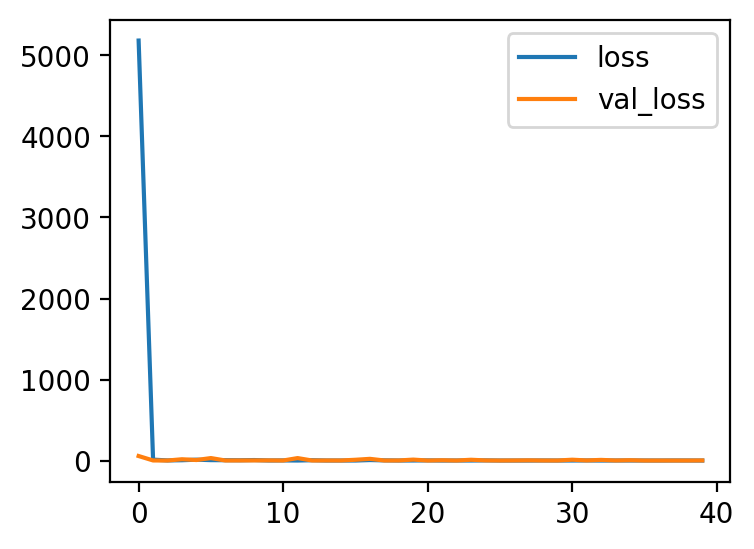

<Figure size 800x600 with 0 Axes>

{'loss': 0.8369361758232117, 'mse': 0.8369361758232117, 'val_loss': 2.3621203899383545, 'val_mse': 2.3621203899383545}
46/46 [==============================] - 1s 32ms/step - loss: 0.8369 - mse: 0.8369 - val_loss: 2.3621 - val_mse: 2.3621
Epoch 41/100
45/46 [============================>.] - ETA: 0s - loss: 0.9577 - mse: 0.9577
Epoch 41: val_loss improved from 1.15774 to 1.15183, saving model to models/dscovrmatic-mlp-v1-e41
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e41/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e41/assets


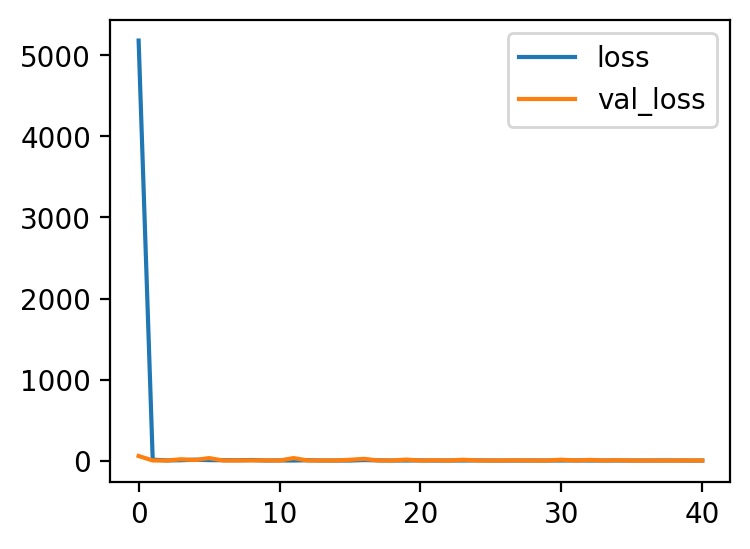

<Figure size 800x600 with 0 Axes>

{'loss': 0.9571958184242249, 'mse': 0.9571958184242249, 'val_loss': 1.151832938194275, 'val_mse': 1.151832938194275}
46/46 [==============================] - 6s 133ms/step - loss: 0.9572 - mse: 0.9572 - val_loss: 1.1518 - val_mse: 1.1518
Epoch 42/100
45/46 [============================>.] - ETA: 0s - loss: 1.0058 - mse: 1.0058
Epoch 42: val_loss did not improve from 1.15183


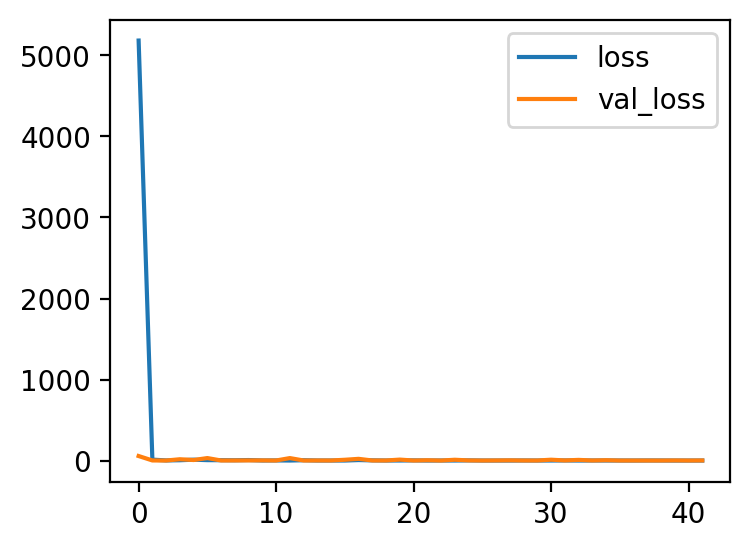

<Figure size 800x600 with 0 Axes>

{'loss': 1.0048940181732178, 'mse': 1.0048940181732178, 'val_loss': 2.099980354309082, 'val_mse': 2.099980354309082}
46/46 [==============================] - 1s 31ms/step - loss: 1.0049 - mse: 1.0049 - val_loss: 2.1000 - val_mse: 2.1000
Epoch 43/100
45/46 [============================>.] - ETA: 0s - loss: 1.0784 - mse: 1.0784
Epoch 43: val_loss did not improve from 1.15183


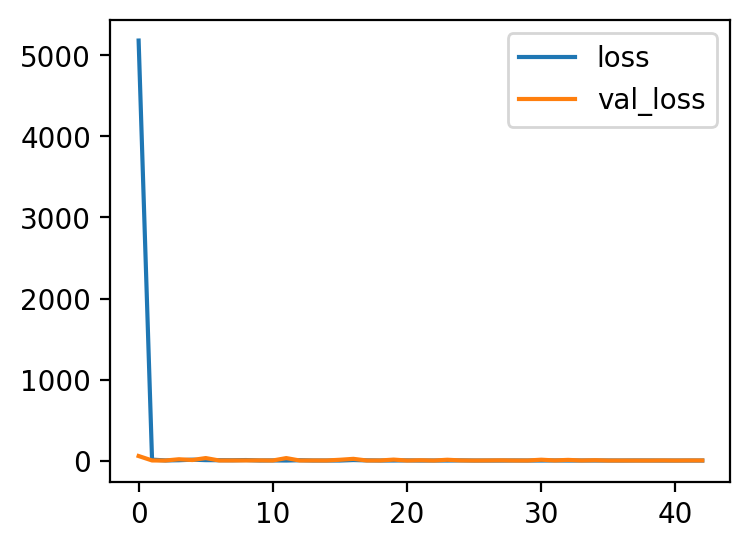

<Figure size 800x600 with 0 Axes>

{'loss': 1.077003002166748, 'mse': 1.077003002166748, 'val_loss': 2.078299045562744, 'val_mse': 2.078299045562744}
46/46 [==============================] - 1s 31ms/step - loss: 1.0770 - mse: 1.0770 - val_loss: 2.0783 - val_mse: 2.0783
Epoch 44/100
45/46 [============================>.] - ETA: 0s - loss: 0.9951 - mse: 0.9951
Epoch 44: val_loss did not improve from 1.15183


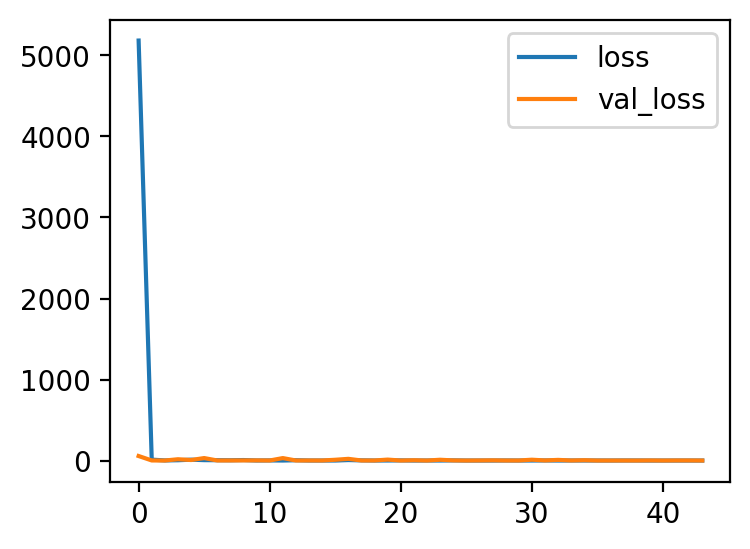

<Figure size 800x600 with 0 Axes>

{'loss': 0.9951013326644897, 'mse': 0.9951013326644897, 'val_loss': 1.167389988899231, 'val_mse': 1.167389988899231}
46/46 [==============================] - 1s 31ms/step - loss: 0.9951 - mse: 0.9951 - val_loss: 1.1674 - val_mse: 1.1674
Epoch 45/100
45/46 [============================>.] - ETA: 0s - loss: 1.7523 - mse: 1.7523
Epoch 45: val_loss did not improve from 1.15183


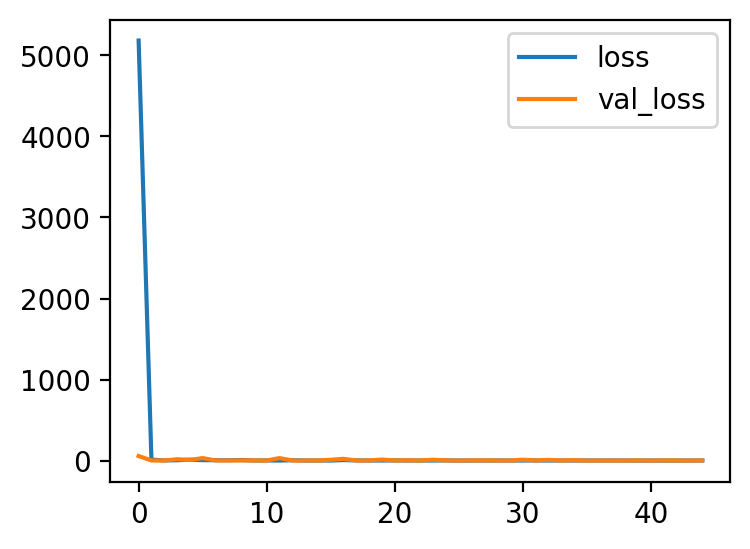

<Figure size 800x600 with 0 Axes>

{'loss': 1.751417636871338, 'mse': 1.751417636871338, 'val_loss': 2.3085482120513916, 'val_mse': 2.3085482120513916}
46/46 [==============================] - 1s 31ms/step - loss: 1.7514 - mse: 1.7514 - val_loss: 2.3085 - val_mse: 2.3085
Epoch 46/100
45/46 [============================>.] - ETA: 0s - loss: 1.1943 - mse: 1.1943
Epoch 46: val_loss did not improve from 1.15183


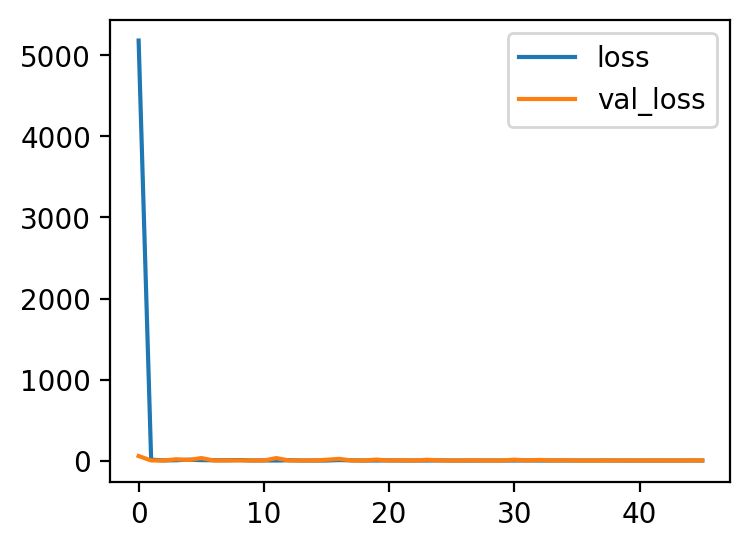

<Figure size 800x600 with 0 Axes>

{'loss': 1.1951031684875488, 'mse': 1.1951031684875488, 'val_loss': 2.4027435779571533, 'val_mse': 2.4027435779571533}
46/46 [==============================] - 1s 31ms/step - loss: 1.1951 - mse: 1.1951 - val_loss: 2.4027 - val_mse: 2.4027
Epoch 47/100
45/46 [============================>.] - ETA: 0s - loss: 1.2686 - mse: 1.2686
Epoch 47: val_loss did not improve from 1.15183


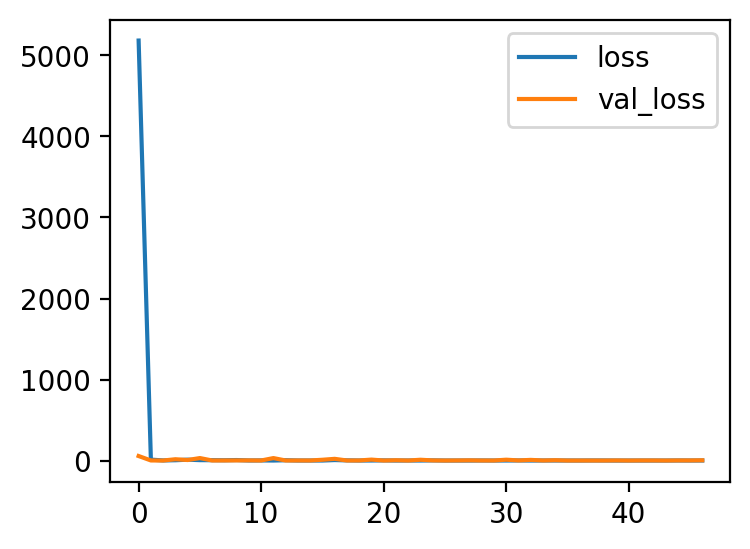

<Figure size 800x600 with 0 Axes>

{'loss': 1.2676957845687866, 'mse': 1.2676957845687866, 'val_loss': 4.1118974685668945, 'val_mse': 4.1118974685668945}
46/46 [==============================] - 1s 31ms/step - loss: 1.2677 - mse: 1.2677 - val_loss: 4.1119 - val_mse: 4.1119
Epoch 48/100
45/46 [============================>.] - ETA: 0s - loss: 1.7510 - mse: 1.7510
Epoch 48: val_loss improved from 1.15183 to 1.06679, saving model to models/dscovrmatic-mlp-v1-e48
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(228960, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54f52a60>, 139957229356496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e47b50>, 139957229650160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 1024), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e53a90>, 139957229406448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54defb50>, 139957229406928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1024, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54e0ea60>, 139957229429424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54d9eb20>, 139957229429904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54db1a00>, 139957229431744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4a54dc1ac0>, 139957229432224), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e48/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-mlp-v1-e48/assets


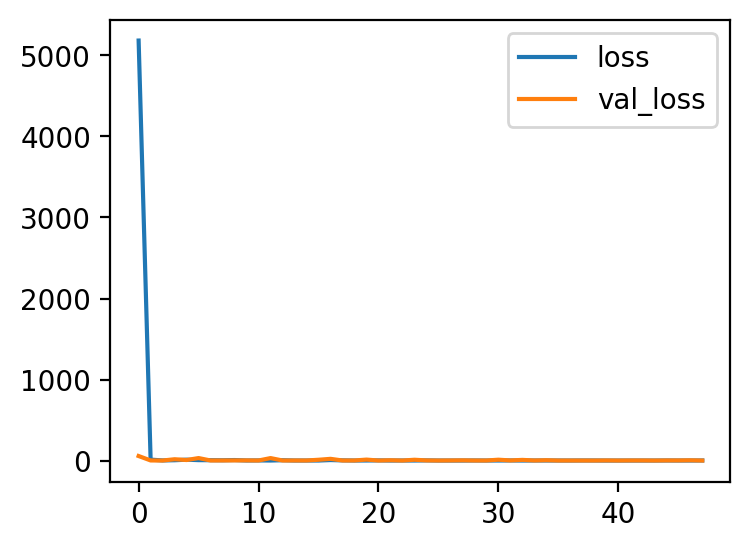

<Figure size 800x600 with 0 Axes>

{'loss': 1.750471830368042, 'mse': 1.750471830368042, 'val_loss': 1.0667880773544312, 'val_mse': 1.0667880773544312}
46/46 [==============================] - 6s 134ms/step - loss: 1.7505 - mse: 1.7505 - val_loss: 1.0668 - val_mse: 1.0668
Epoch 49/100
45/46 [============================>.] - ETA: 0s - loss: 0.8655 - mse: 0.8655
Epoch 49: val_loss did not improve from 1.06679


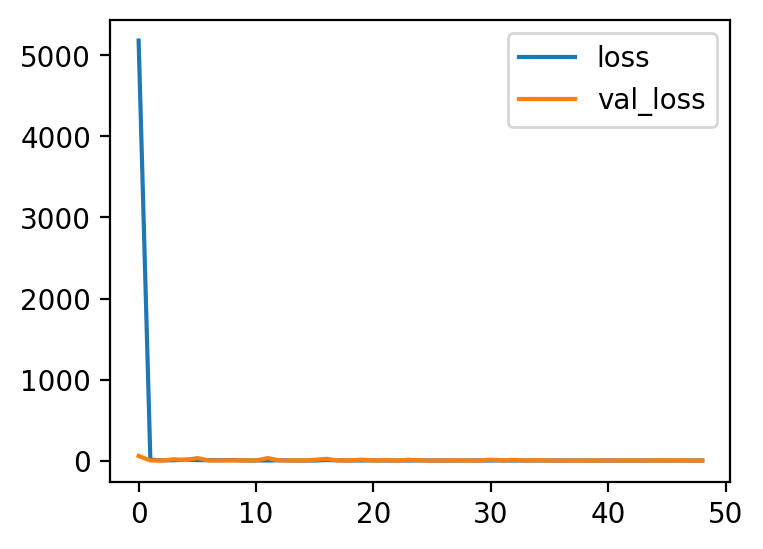

<Figure size 800x600 with 0 Axes>

{'loss': 0.8656295537948608, 'mse': 0.8656295537948608, 'val_loss': 1.3073146343231201, 'val_mse': 1.3073146343231201}
46/46 [==============================] - 1s 31ms/step - loss: 0.8656 - mse: 0.8656 - val_loss: 1.3073 - val_mse: 1.3073
Epoch 50/100
45/46 [============================>.] - ETA: 0s - loss: 0.8335 - mse: 0.8335
Epoch 50: val_loss did not improve from 1.06679


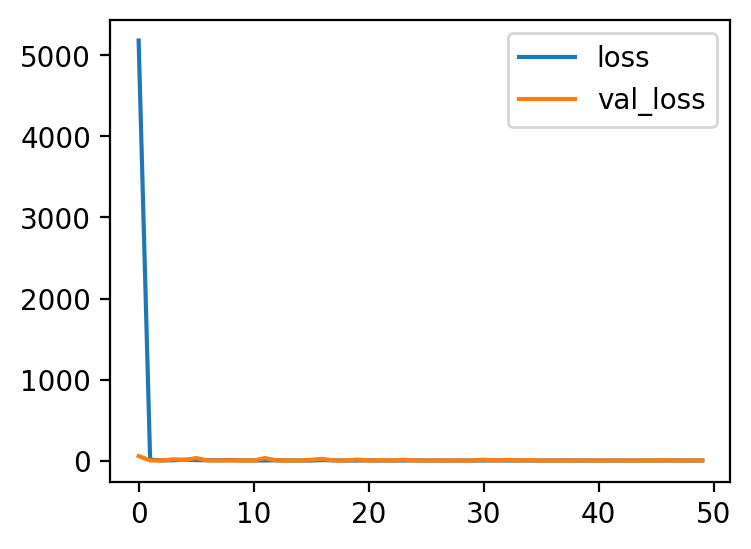

<Figure size 800x600 with 0 Axes>

{'loss': 0.8347769975662231, 'mse': 0.8347769975662231, 'val_loss': 2.4731287956237793, 'val_mse': 2.4731287956237793}
46/46 [==============================] - 1s 31ms/step - loss: 0.8348 - mse: 0.8348 - val_loss: 2.4731 - val_mse: 2.4731
Epoch 51/100
45/46 [============================>.] - ETA: 0s - loss: 1.0892 - mse: 1.0892
Epoch 51: val_loss did not improve from 1.06679


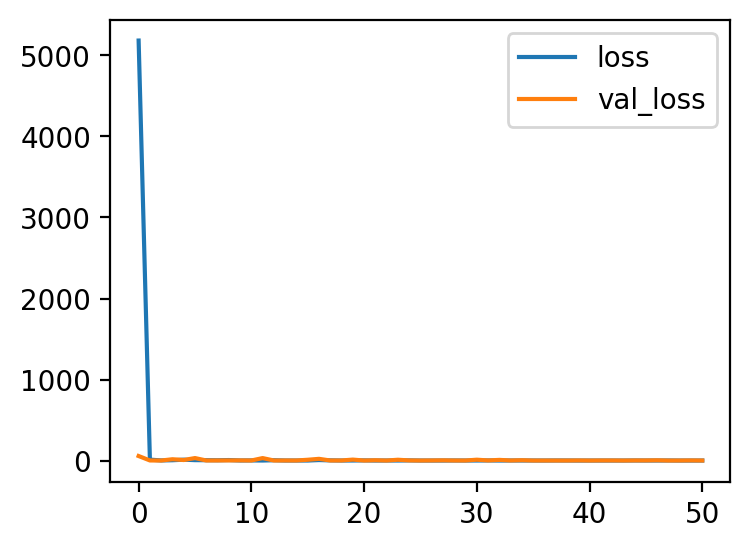

<Figure size 800x600 with 0 Axes>

{'loss': 1.0913175344467163, 'mse': 1.0913175344467163, 'val_loss': 1.3204265832901, 'val_mse': 1.3204265832901}
46/46 [==============================] - 1s 31ms/step - loss: 1.0913 - mse: 1.0913 - val_loss: 1.3204 - val_mse: 1.3204
Epoch 52/100
45/46 [============================>.] - ETA: 0s - loss: 1.0451 - mse: 1.0451
Epoch 52: val_loss did not improve from 1.06679


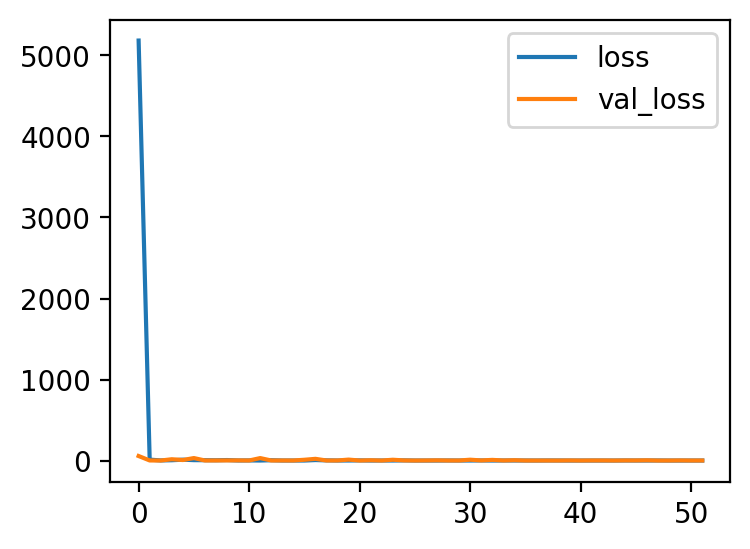

<Figure size 800x600 with 0 Axes>

{'loss': 1.0436841249465942, 'mse': 1.0436841249465942, 'val_loss': 1.5015288591384888, 'val_mse': 1.5015288591384888}
46/46 [==============================] - 1s 32ms/step - loss: 1.0437 - mse: 1.0437 - val_loss: 1.5015 - val_mse: 1.5015
Epoch 53/100
45/46 [============================>.] - ETA: 0s - loss: 0.7791 - mse: 0.7791
Epoch 53: val_loss did not improve from 1.06679


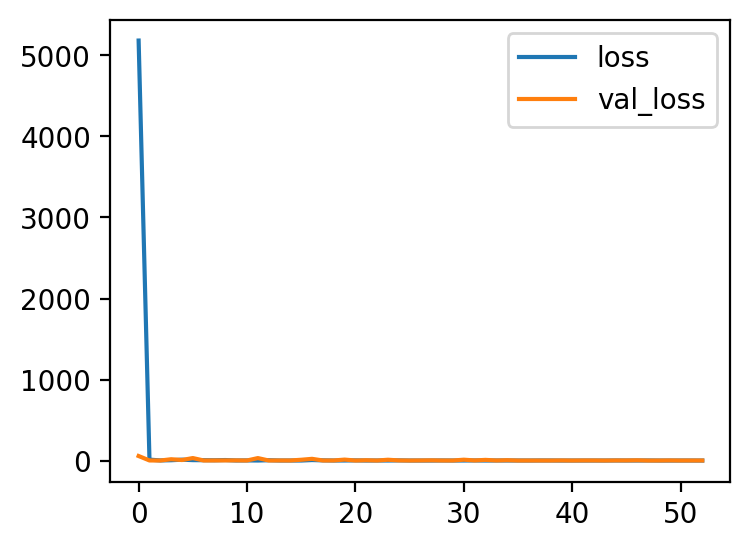

<Figure size 800x600 with 0 Axes>

{'loss': 0.7780362367630005, 'mse': 0.7780362367630005, 'val_loss': 1.5255457162857056, 'val_mse': 1.5255457162857056}
46/46 [==============================] - 1s 32ms/step - loss: 0.7780 - mse: 0.7780 - val_loss: 1.5255 - val_mse: 1.5255
Epoch 54/100
45/46 [============================>.] - ETA: 0s - loss: 1.0897 - mse: 1.0897
Epoch 54: val_loss did not improve from 1.06679


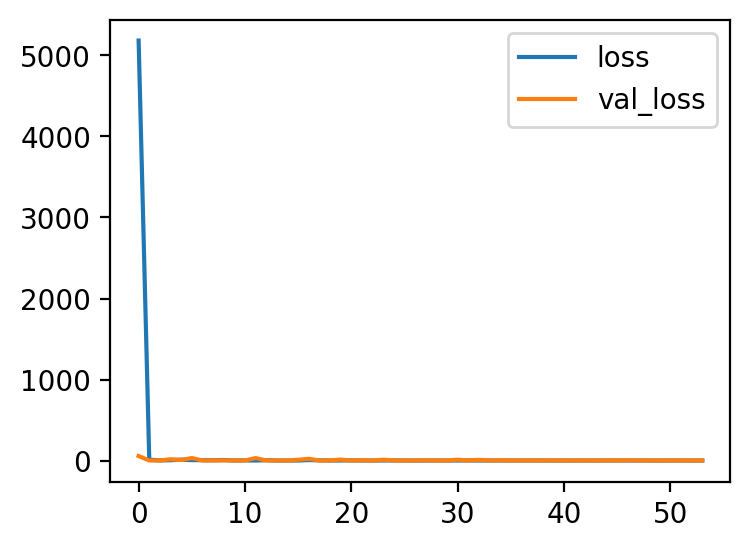

<Figure size 800x600 with 0 Axes>

{'loss': 1.0888639688491821, 'mse': 1.0888639688491821, 'val_loss': 1.2512383460998535, 'val_mse': 1.2512383460998535}
46/46 [==============================] - 1s 32ms/step - loss: 1.0889 - mse: 1.0889 - val_loss: 1.2512 - val_mse: 1.2512
Epoch 55/100
45/46 [============================>.] - ETA: 0s - loss: 0.7873 - mse: 0.7873
Epoch 55: val_loss did not improve from 1.06679


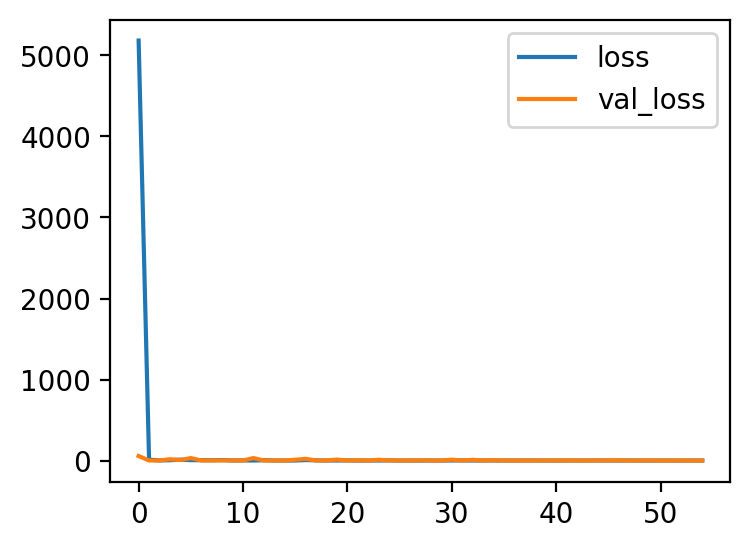

<Figure size 800x600 with 0 Axes>

{'loss': 0.7868878245353699, 'mse': 0.7868878245353699, 'val_loss': 1.3352705240249634, 'val_mse': 1.3352705240249634}
46/46 [==============================] - 2s 35ms/step - loss: 0.7869 - mse: 0.7869 - val_loss: 1.3353 - val_mse: 1.3353
Epoch 56/100
45/46 [============================>.] - ETA: 0s - loss: 1.1937 - mse: 1.1937
Epoch 56: val_loss did not improve from 1.06679


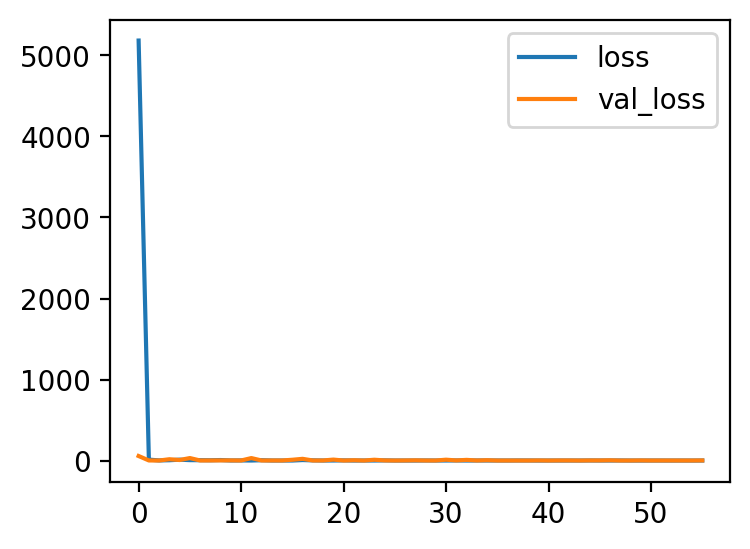

<Figure size 800x600 with 0 Axes>

{'loss': 1.192650556564331, 'mse': 1.192650556564331, 'val_loss': 2.2767999172210693, 'val_mse': 2.2767999172210693}
46/46 [==============================] - 1s 32ms/step - loss: 1.1927 - mse: 1.1927 - val_loss: 2.2768 - val_mse: 2.2768
Epoch 57/100
45/46 [============================>.] - ETA: 0s - loss: 0.7552 - mse: 0.7552
Epoch 57: val_loss did not improve from 1.06679


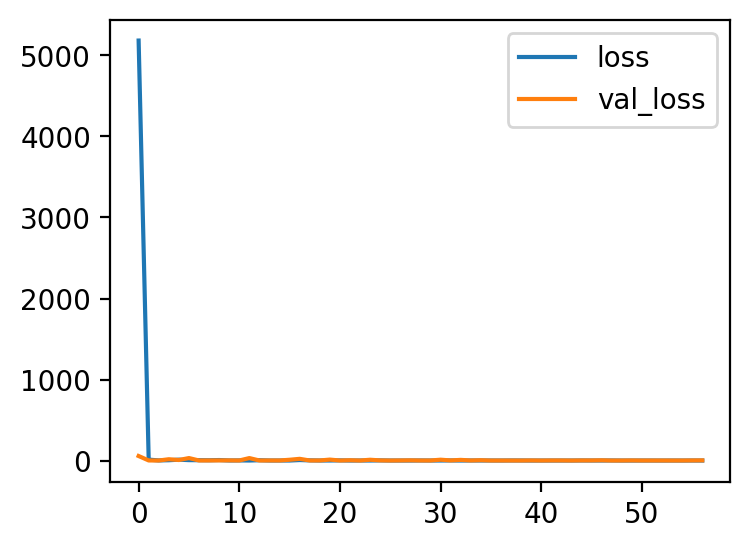

<Figure size 800x600 with 0 Axes>

{'loss': 0.755268931388855, 'mse': 0.755268931388855, 'val_loss': 3.060720682144165, 'val_mse': 3.060720682144165}
46/46 [==============================] - 1s 32ms/step - loss: 0.7553 - mse: 0.7553 - val_loss: 3.0607 - val_mse: 3.0607
Epoch 58/100
45/46 [============================>.] - ETA: 0s - loss: 1.0370 - mse: 1.0370
Epoch 58: val_loss did not improve from 1.06679


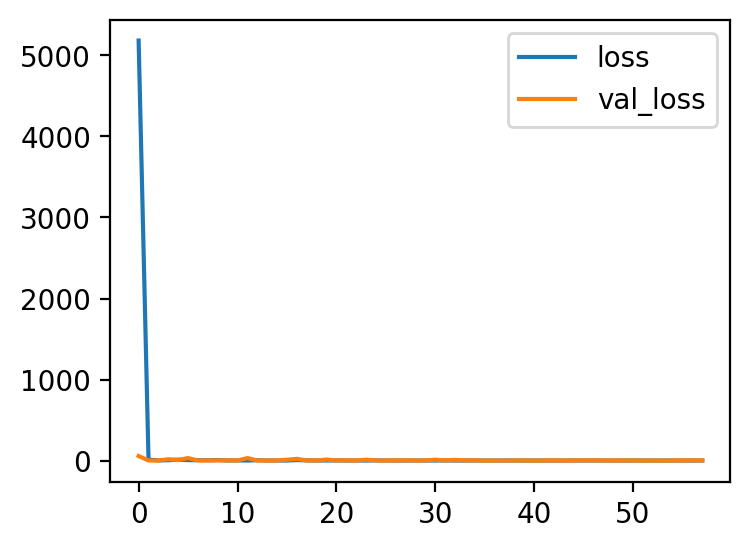

<Figure size 800x600 with 0 Axes>

{'loss': 1.036592721939087, 'mse': 1.036592721939087, 'val_loss': 2.0051209926605225, 'val_mse': 2.0051209926605225}
46/46 [==============================] - 1s 31ms/step - loss: 1.0366 - mse: 1.0366 - val_loss: 2.0051 - val_mse: 2.0051
Epoch 59/100
45/46 [============================>.] - ETA: 0s - loss: 0.9169 - mse: 0.9169
Epoch 59: val_loss did not improve from 1.06679


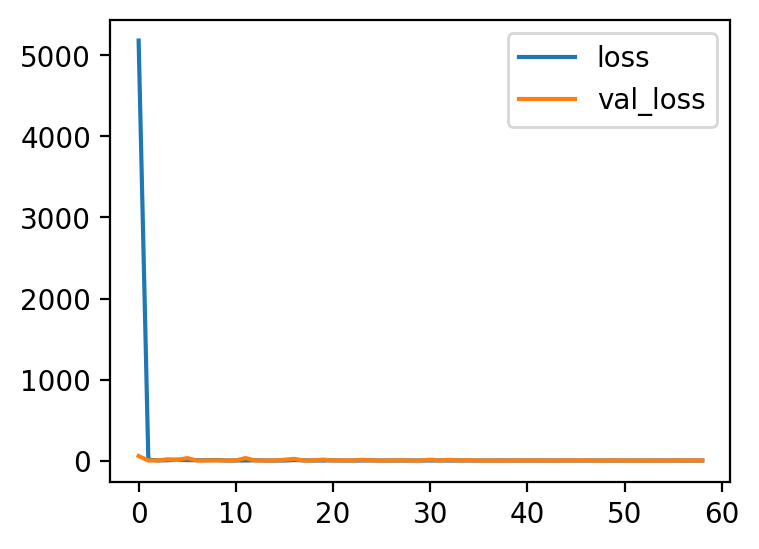

<Figure size 800x600 with 0 Axes>

{'loss': 0.924231767654419, 'mse': 0.924231767654419, 'val_loss': 2.1531453132629395, 'val_mse': 2.1531453132629395}
46/46 [==============================] - 1s 32ms/step - loss: 0.9242 - mse: 0.9242 - val_loss: 2.1531 - val_mse: 2.1531
Epoch 60/100
45/46 [============================>.] - ETA: 0s - loss: 1.1310 - mse: 1.1310
Epoch 60: val_loss did not improve from 1.06679


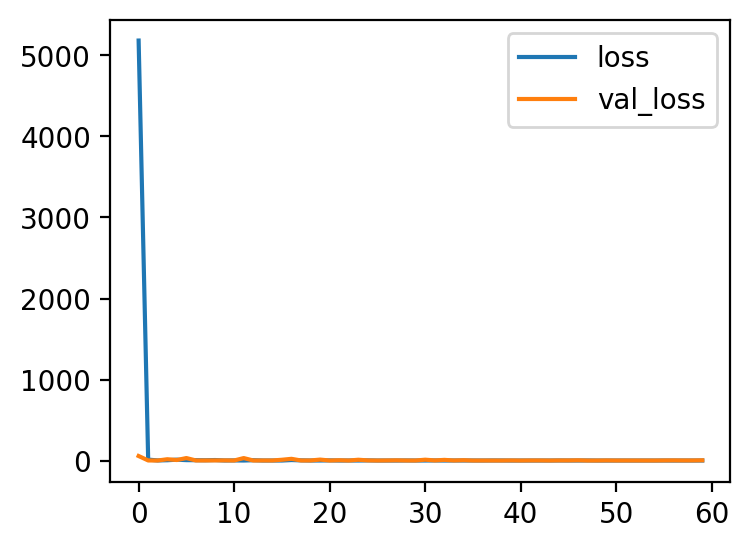

<Figure size 800x600 with 0 Axes>

{'loss': 1.1303627490997314, 'mse': 1.1303627490997314, 'val_loss': 3.9608466625213623, 'val_mse': 3.9608466625213623}
46/46 [==============================] - 1s 32ms/step - loss: 1.1304 - mse: 1.1304 - val_loss: 3.9608 - val_mse: 3.9608
Epoch 61/100
45/46 [============================>.] - ETA: 0s - loss: 1.1088 - mse: 1.1088
Epoch 61: val_loss did not improve from 1.06679


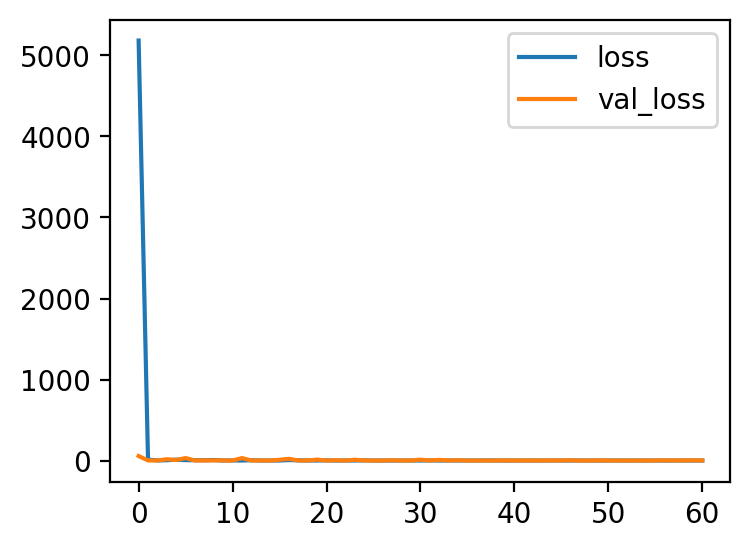

<Figure size 800x600 with 0 Axes>

{'loss': 1.1093251705169678, 'mse': 1.1093251705169678, 'val_loss': 1.8766556978225708, 'val_mse': 1.8766556978225708}
46/46 [==============================] - 1s 31ms/step - loss: 1.1093 - mse: 1.1093 - val_loss: 1.8767 - val_mse: 1.8767
Epoch 62/100
45/46 [============================>.] - ETA: 0s - loss: 1.0418 - mse: 1.0418
Epoch 62: val_loss did not improve from 1.06679


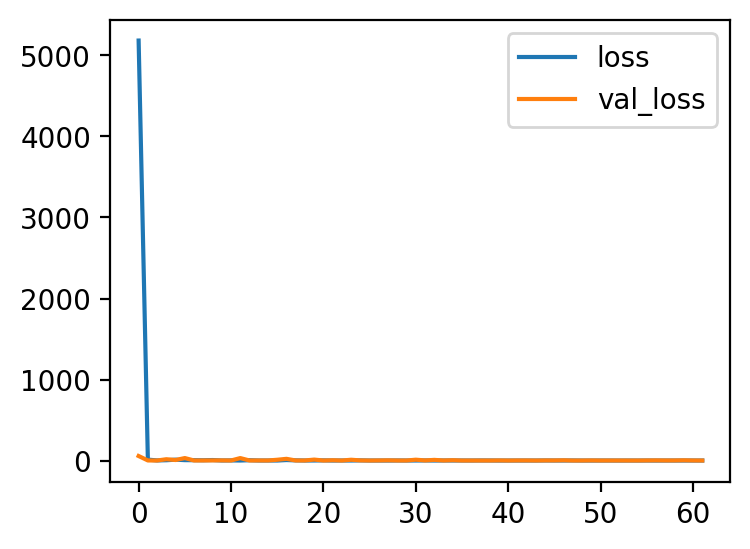

<Figure size 800x600 with 0 Axes>

{'loss': 1.0430415868759155, 'mse': 1.0430415868759155, 'val_loss': 1.1955260038375854, 'val_mse': 1.1955260038375854}
46/46 [==============================] - 1s 32ms/step - loss: 1.0430 - mse: 1.0430 - val_loss: 1.1955 - val_mse: 1.1955
Epoch 63/100
45/46 [============================>.] - ETA: 0s - loss: 0.8018 - mse: 0.8018
Epoch 63: val_loss did not improve from 1.06679


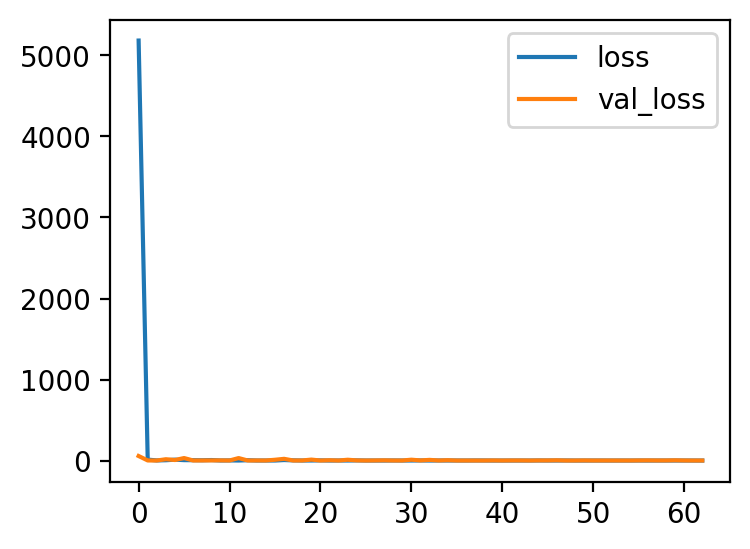

<Figure size 800x600 with 0 Axes>

{'loss': 0.8014914989471436, 'mse': 0.8014914989471436, 'val_loss': 1.2085543870925903, 'val_mse': 1.2085543870925903}
46/46 [==============================] - 1s 31ms/step - loss: 0.8015 - mse: 0.8015 - val_loss: 1.2086 - val_mse: 1.2086
Epoch 64/100
45/46 [============================>.] - ETA: 0s - loss: 0.8139 - mse: 0.8139
Epoch 64: val_loss did not improve from 1.06679


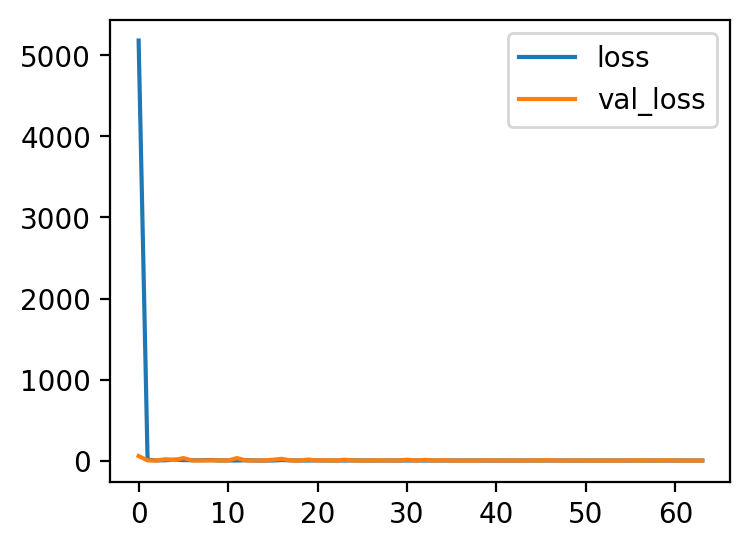

<Figure size 800x600 with 0 Axes>

{'loss': 0.8128021359443665, 'mse': 0.8128021359443665, 'val_loss': 1.3217898607254028, 'val_mse': 1.3217898607254028}
46/46 [==============================] - 1s 31ms/step - loss: 0.8128 - mse: 0.8128 - val_loss: 1.3218 - val_mse: 1.3218
Epoch 65/100
45/46 [============================>.] - ETA: 0s - loss: 0.8649 - mse: 0.8649
Epoch 65: val_loss did not improve from 1.06679


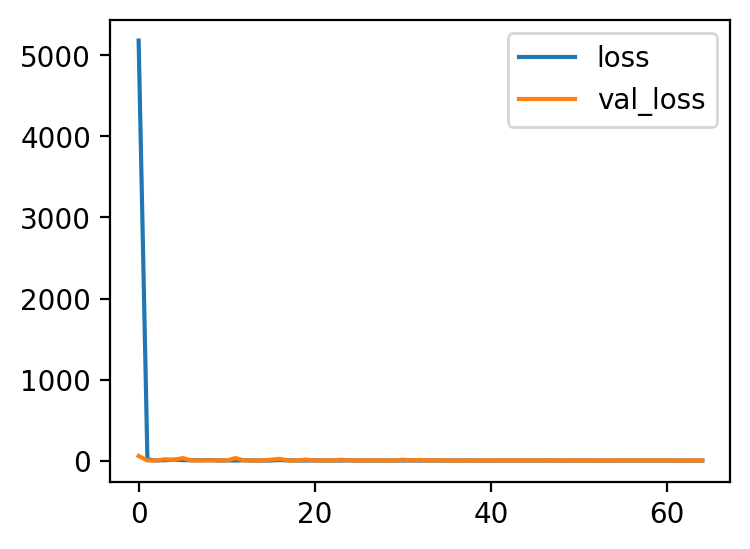

<Figure size 800x600 with 0 Axes>

{'loss': 0.8644053339958191, 'mse': 0.8644053339958191, 'val_loss': 1.209870457649231, 'val_mse': 1.209870457649231}
46/46 [==============================] - 1s 31ms/step - loss: 0.8644 - mse: 0.8644 - val_loss: 1.2099 - val_mse: 1.2099
Epoch 66/100
45/46 [============================>.] - ETA: 0s - loss: 0.8194 - mse: 0.8194
Epoch 66: val_loss did not improve from 1.06679


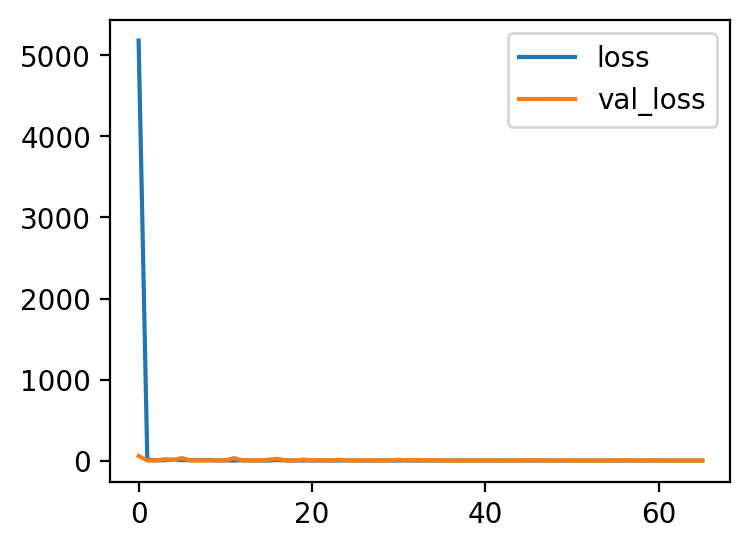

<Figure size 800x600 with 0 Axes>

{'loss': 0.8198450207710266, 'mse': 0.8198450207710266, 'val_loss': 1.182457447052002, 'val_mse': 1.182457447052002}
46/46 [==============================] - 1s 31ms/step - loss: 0.8198 - mse: 0.8198 - val_loss: 1.1825 - val_mse: 1.1825
Epoch 67/100
45/46 [============================>.] - ETA: 0s - loss: 0.7532 - mse: 0.7532
Epoch 67: val_loss did not improve from 1.06679


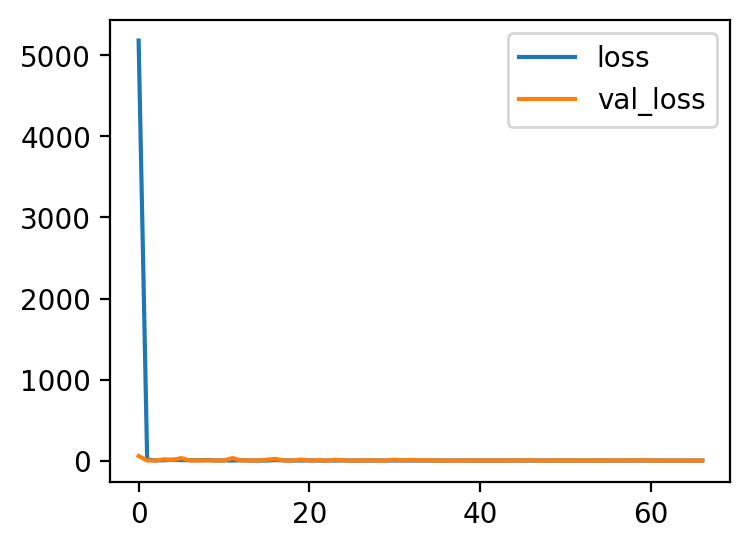

<Figure size 800x600 with 0 Axes>

{'loss': 0.7532455921173096, 'mse': 0.7532455921173096, 'val_loss': 1.1862903833389282, 'val_mse': 1.1862903833389282}
46/46 [==============================] - 1s 31ms/step - loss: 0.7532 - mse: 0.7532 - val_loss: 1.1863 - val_mse: 1.1863
Epoch 68/100
45/46 [============================>.] - ETA: 0s - loss: 0.8596 - mse: 0.8596
Epoch 68: val_loss did not improve from 1.06679


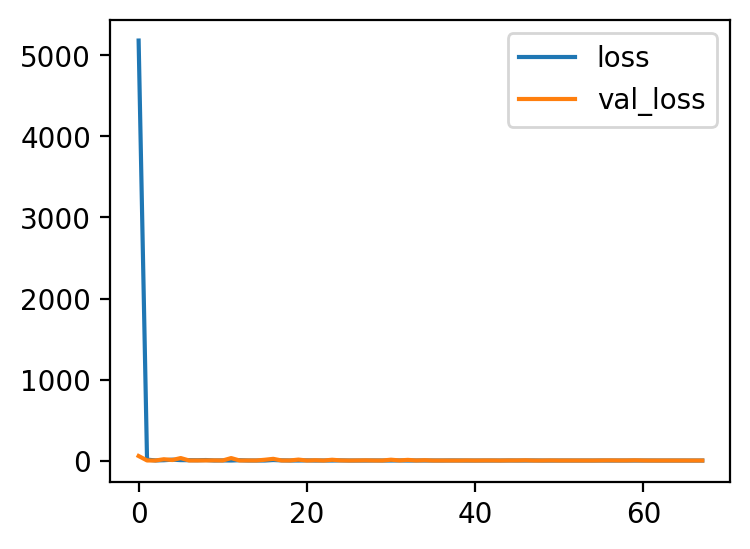

<Figure size 800x600 with 0 Axes>

{'loss': 0.8586767911911011, 'mse': 0.8586767911911011, 'val_loss': 1.1874243021011353, 'val_mse': 1.1874243021011353}
46/46 [==============================] - 1s 31ms/step - loss: 0.8587 - mse: 0.8587 - val_loss: 1.1874 - val_mse: 1.1874
Epoch 69/100
45/46 [============================>.] - ETA: 0s - loss: 0.7782 - mse: 0.7782
Epoch 69: val_loss did not improve from 1.06679


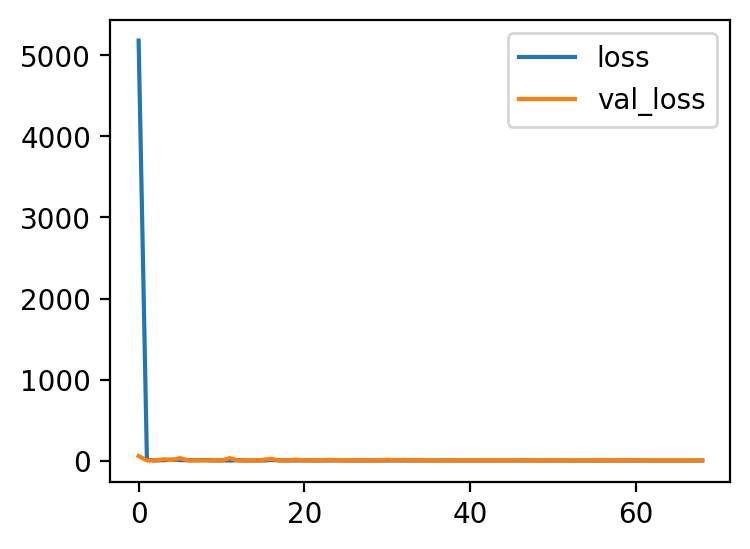

<Figure size 800x600 with 0 Axes>

{'loss': 0.781325101852417, 'mse': 0.781325101852417, 'val_loss': 2.6137683391571045, 'val_mse': 2.6137683391571045}
46/46 [==============================] - 1s 31ms/step - loss: 0.7813 - mse: 0.7813 - val_loss: 2.6138 - val_mse: 2.6138
Epoch 70/100
45/46 [============================>.] - ETA: 0s - loss: 1.0355 - mse: 1.0355
Epoch 70: val_loss did not improve from 1.06679


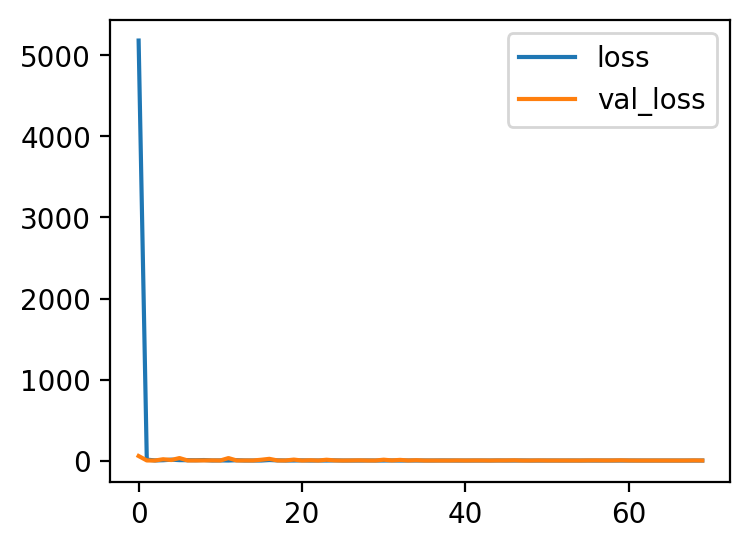

<Figure size 800x600 with 0 Axes>

{'loss': 1.034104824066162, 'mse': 1.034104824066162, 'val_loss': 1.2541701793670654, 'val_mse': 1.2541701793670654}
46/46 [==============================] - 1s 31ms/step - loss: 1.0341 - mse: 1.0341 - val_loss: 1.2542 - val_mse: 1.2542
Epoch 71/100
45/46 [============================>.] - ETA: 0s - loss: 0.7450 - mse: 0.7450
Epoch 71: val_loss did not improve from 1.06679


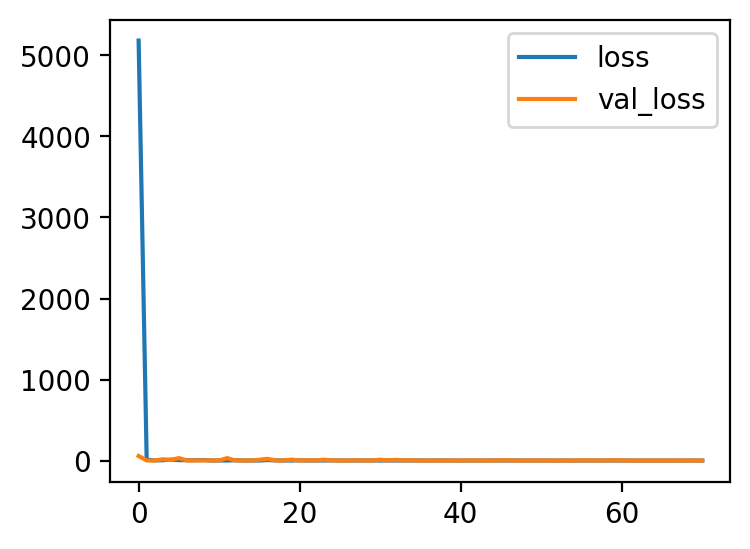

<Figure size 800x600 with 0 Axes>

{'loss': 0.744268000125885, 'mse': 0.744268000125885, 'val_loss': 1.3457056283950806, 'val_mse': 1.3457056283950806}
46/46 [==============================] - 1s 31ms/step - loss: 0.7443 - mse: 0.7443 - val_loss: 1.3457 - val_mse: 1.3457
Epoch 72/100
45/46 [============================>.] - ETA: 0s - loss: 0.8068 - mse: 0.8068
Epoch 72: val_loss did not improve from 1.06679


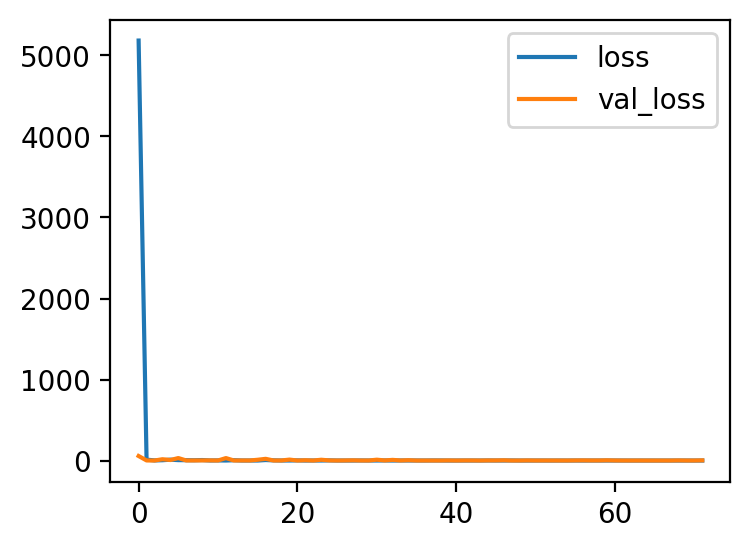

<Figure size 800x600 with 0 Axes>

{'loss': 0.8062318563461304, 'mse': 0.8062318563461304, 'val_loss': 3.1845128536224365, 'val_mse': 3.1845128536224365}
46/46 [==============================] - 1s 31ms/step - loss: 0.8062 - mse: 0.8062 - val_loss: 3.1845 - val_mse: 3.1845
Epoch 73/100
45/46 [============================>.] - ETA: 0s - loss: 0.9293 - mse: 0.9293
Epoch 73: val_loss did not improve from 1.06679


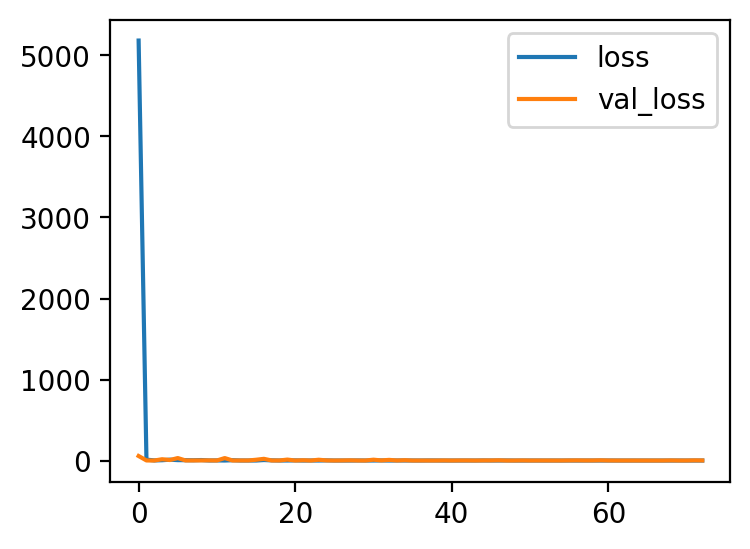

<Figure size 800x600 with 0 Axes>

{'loss': 0.9286315441131592, 'mse': 0.9286315441131592, 'val_loss': 2.090441942214966, 'val_mse': 2.090441942214966}
46/46 [==============================] - 1s 31ms/step - loss: 0.9286 - mse: 0.9286 - val_loss: 2.0904 - val_mse: 2.0904
Epoch 74/100
45/46 [============================>.] - ETA: 0s - loss: 0.7471 - mse: 0.7471
Epoch 74: val_loss did not improve from 1.06679


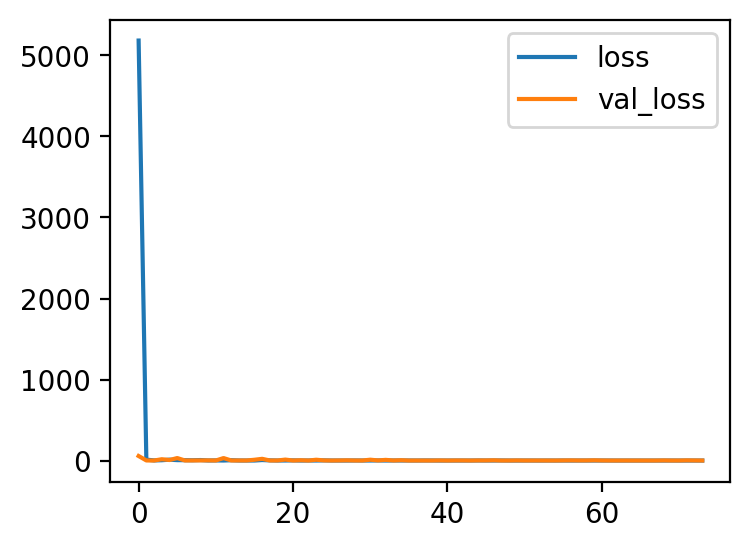

<Figure size 800x600 with 0 Axes>

{'loss': 0.7461705207824707, 'mse': 0.7461705207824707, 'val_loss': 1.2270255088806152, 'val_mse': 1.2270255088806152}
46/46 [==============================] - 1s 31ms/step - loss: 0.7462 - mse: 0.7462 - val_loss: 1.2270 - val_mse: 1.2270
Epoch 75/100
45/46 [============================>.] - ETA: 0s - loss: 0.7506 - mse: 0.7506
Epoch 75: val_loss did not improve from 1.06679


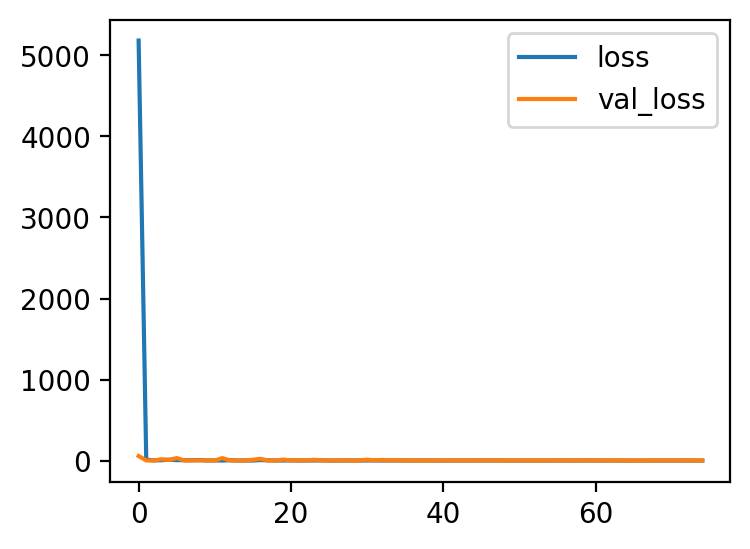

<Figure size 800x600 with 0 Axes>

{'loss': 0.7500288486480713, 'mse': 0.7500288486480713, 'val_loss': 1.1923511028289795, 'val_mse': 1.1923511028289795}
46/46 [==============================] - 1s 31ms/step - loss: 0.7500 - mse: 0.7500 - val_loss: 1.1924 - val_mse: 1.1924
Epoch 76/100
45/46 [============================>.] - ETA: 0s - loss: 0.8126 - mse: 0.8126
Epoch 76: val_loss did not improve from 1.06679


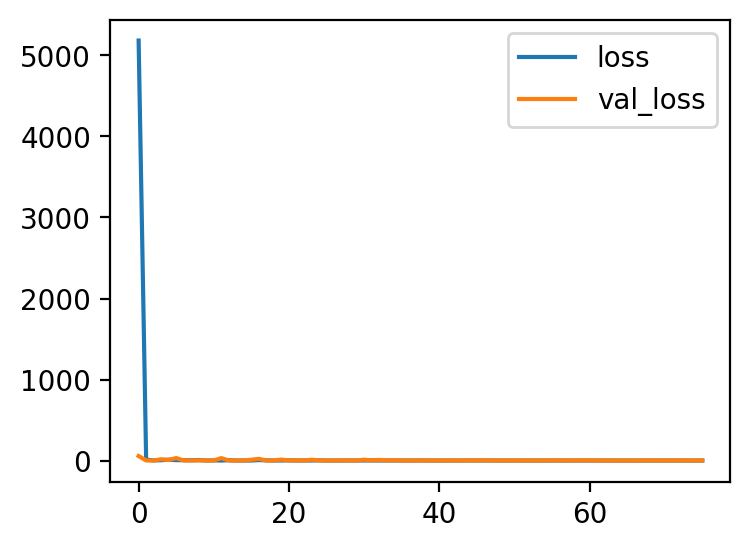

<Figure size 800x600 with 0 Axes>

{'loss': 0.8119851350784302, 'mse': 0.8119851350784302, 'val_loss': 1.7916194200515747, 'val_mse': 1.7916194200515747}
46/46 [==============================] - 1s 31ms/step - loss: 0.8120 - mse: 0.8120 - val_loss: 1.7916 - val_mse: 1.7916
Epoch 77/100
45/46 [============================>.] - ETA: 0s - loss: 0.7415 - mse: 0.7415
Epoch 77: val_loss did not improve from 1.06679


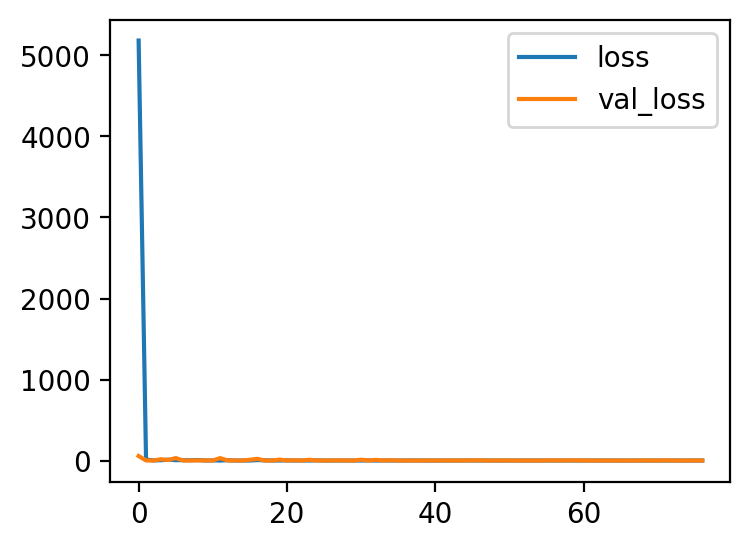

<Figure size 800x600 with 0 Axes>

{'loss': 0.7427888512611389, 'mse': 0.7427888512611389, 'val_loss': 1.472383737564087, 'val_mse': 1.472383737564087}
46/46 [==============================] - 1s 31ms/step - loss: 0.7428 - mse: 0.7428 - val_loss: 1.4724 - val_mse: 1.4724
Epoch 78/100
45/46 [============================>.] - ETA: 0s - loss: 1.0354 - mse: 1.0354
Epoch 78: val_loss did not improve from 1.06679


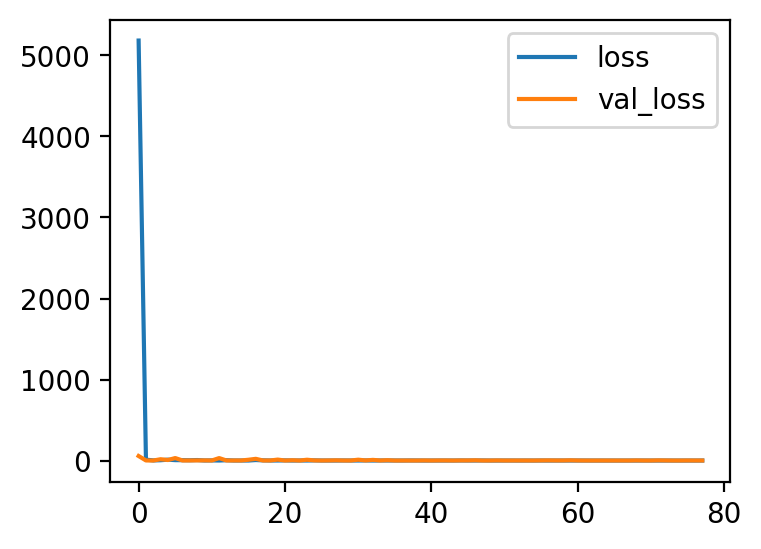

<Figure size 800x600 with 0 Axes>

{'loss': 1.036136269569397, 'mse': 1.036136269569397, 'val_loss': 1.3659108877182007, 'val_mse': 1.3659108877182007}
46/46 [==============================] - 1s 32ms/step - loss: 1.0361 - mse: 1.0361 - val_loss: 1.3659 - val_mse: 1.3659
Epoch 79/100
45/46 [============================>.] - ETA: 0s - loss: 0.7740 - mse: 0.7740
Epoch 79: val_loss did not improve from 1.06679


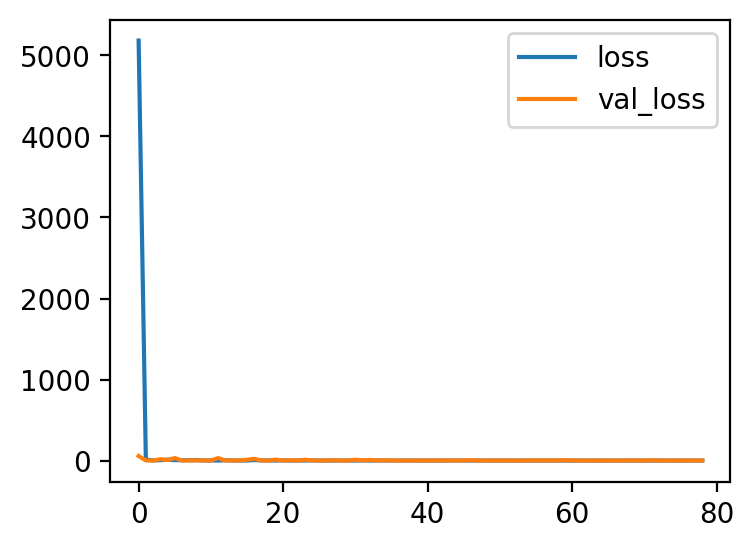

<Figure size 800x600 with 0 Axes>

{'loss': 0.7731412053108215, 'mse': 0.7731412053108215, 'val_loss': 1.5360468626022339, 'val_mse': 1.5360468626022339}
46/46 [==============================] - 1s 32ms/step - loss: 0.7731 - mse: 0.7731 - val_loss: 1.5360 - val_mse: 1.5360
Epoch 80/100
45/46 [============================>.] - ETA: 0s - loss: 0.8220 - mse: 0.8220
Epoch 80: val_loss did not improve from 1.06679


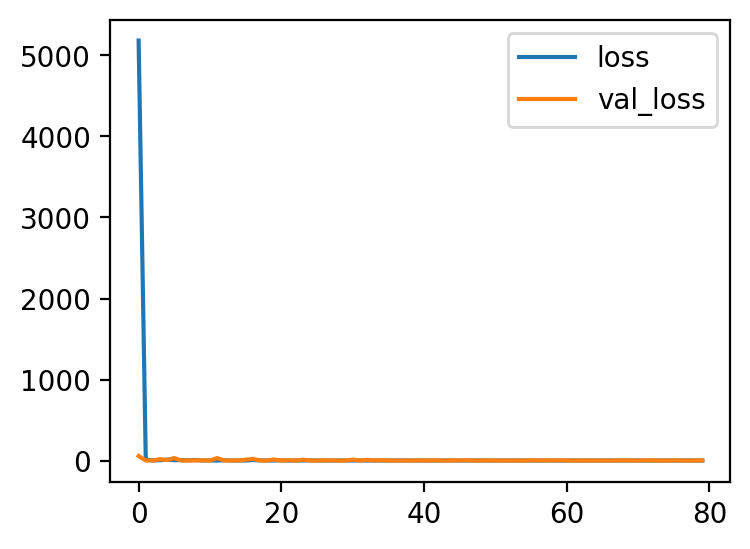

<Figure size 800x600 with 0 Axes>

{'loss': 0.821019172668457, 'mse': 0.821019172668457, 'val_loss': 2.204252004623413, 'val_mse': 2.204252004623413}
46/46 [==============================] - 1s 32ms/step - loss: 0.8210 - mse: 0.8210 - val_loss: 2.2043 - val_mse: 2.2043
Epoch 81/100
45/46 [============================>.] - ETA: 0s - loss: 0.8505 - mse: 0.8505
Epoch 81: val_loss did not improve from 1.06679


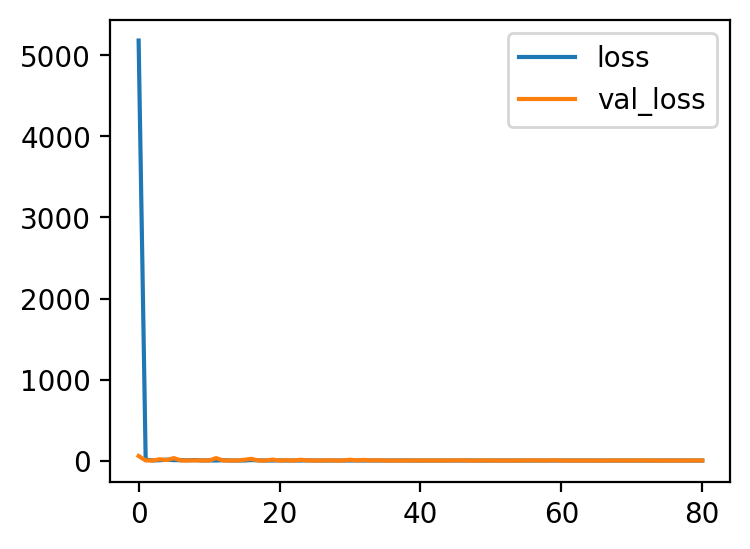

<Figure size 800x600 with 0 Axes>

{'loss': 0.8494309186935425, 'mse': 0.8494309186935425, 'val_loss': 1.2329922914505005, 'val_mse': 1.2329922914505005}
46/46 [==============================] - 1s 31ms/step - loss: 0.8494 - mse: 0.8494 - val_loss: 1.2330 - val_mse: 1.2330
Epoch 82/100
45/46 [============================>.] - ETA: 0s - loss: 0.7630 - mse: 0.7630
Epoch 82: val_loss did not improve from 1.06679


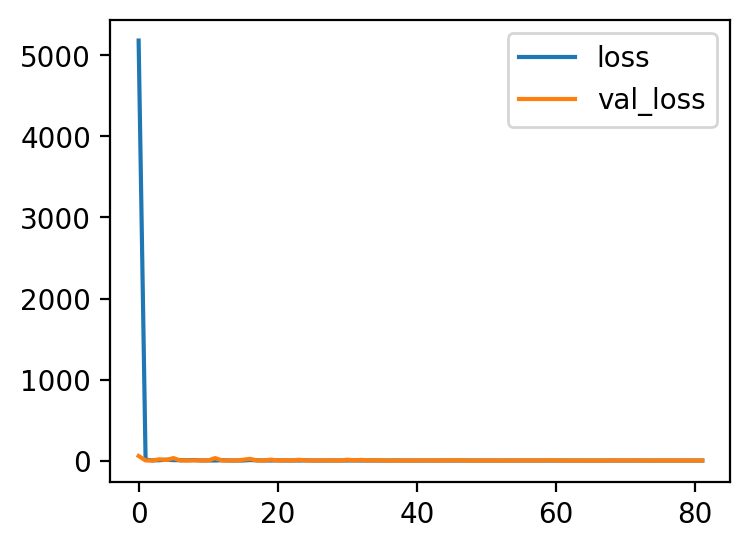

<Figure size 800x600 with 0 Axes>

{'loss': 0.7627905607223511, 'mse': 0.7627905607223511, 'val_loss': 1.2417075634002686, 'val_mse': 1.2417075634002686}
46/46 [==============================] - 1s 31ms/step - loss: 0.7628 - mse: 0.7628 - val_loss: 1.2417 - val_mse: 1.2417
Epoch 83/100
45/46 [============================>.] - ETA: 0s - loss: 0.7292 - mse: 0.7292
Epoch 83: val_loss did not improve from 1.06679


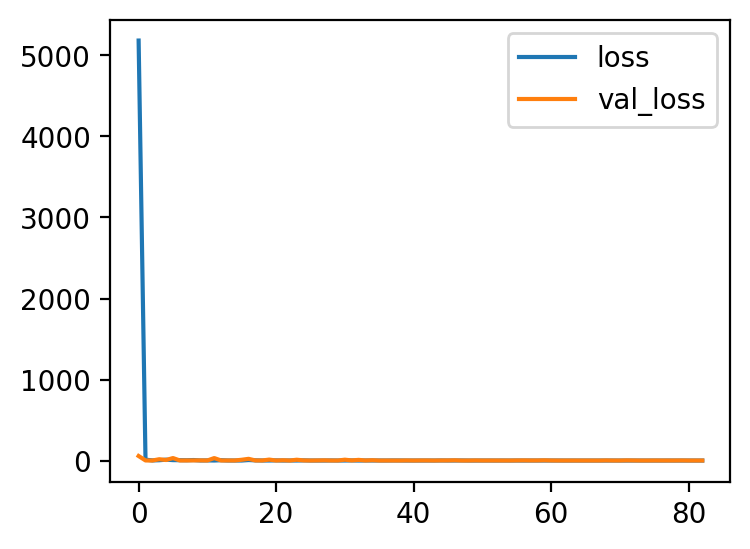

<Figure size 800x600 with 0 Axes>

{'loss': 0.7287039756774902, 'mse': 0.7287039756774902, 'val_loss': 1.2358592748641968, 'val_mse': 1.2358592748641968}
46/46 [==============================] - 1s 31ms/step - loss: 0.7287 - mse: 0.7287 - val_loss: 1.2359 - val_mse: 1.2359
Epoch 84/100
45/46 [============================>.] - ETA: 0s - loss: 0.7693 - mse: 0.7693
Epoch 84: val_loss did not improve from 1.06679


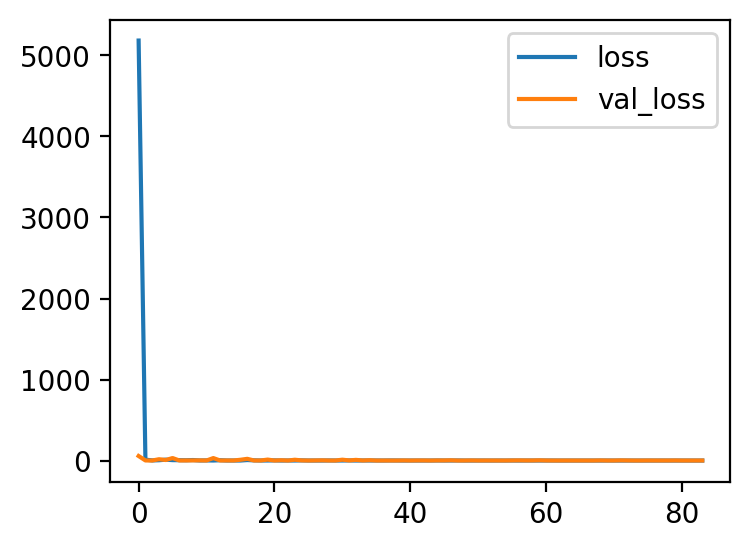

<Figure size 800x600 with 0 Axes>

{'loss': 0.7688463926315308, 'mse': 0.7688463926315308, 'val_loss': 1.3452671766281128, 'val_mse': 1.3452671766281128}
46/46 [==============================] - 1s 31ms/step - loss: 0.7688 - mse: 0.7688 - val_loss: 1.3453 - val_mse: 1.3453
Epoch 85/100
45/46 [============================>.] - ETA: 0s - loss: 0.7570 - mse: 0.7570
Epoch 85: val_loss did not improve from 1.06679


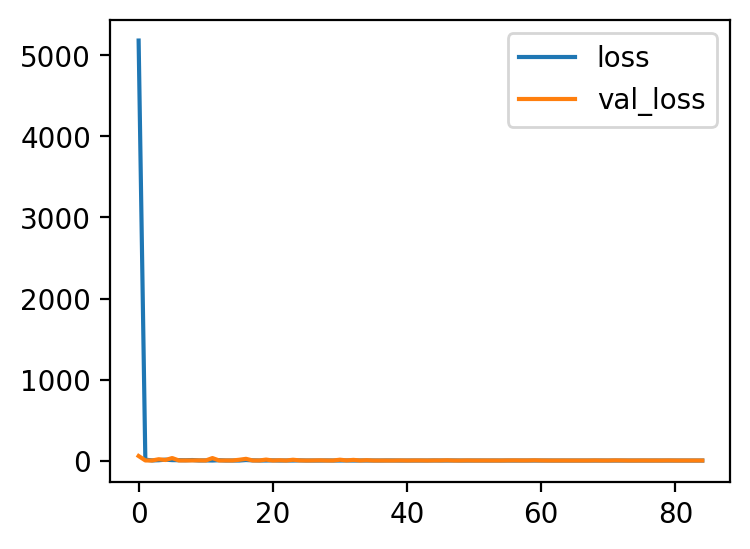

<Figure size 800x600 with 0 Axes>

{'loss': 0.7561127543449402, 'mse': 0.7561127543449402, 'val_loss': 1.2294936180114746, 'val_mse': 1.2294936180114746}
46/46 [==============================] - 1s 31ms/step - loss: 0.7561 - mse: 0.7561 - val_loss: 1.2295 - val_mse: 1.2295
Epoch 86/100
45/46 [============================>.] - ETA: 0s - loss: 0.7417 - mse: 0.7417
Epoch 86: val_loss did not improve from 1.06679


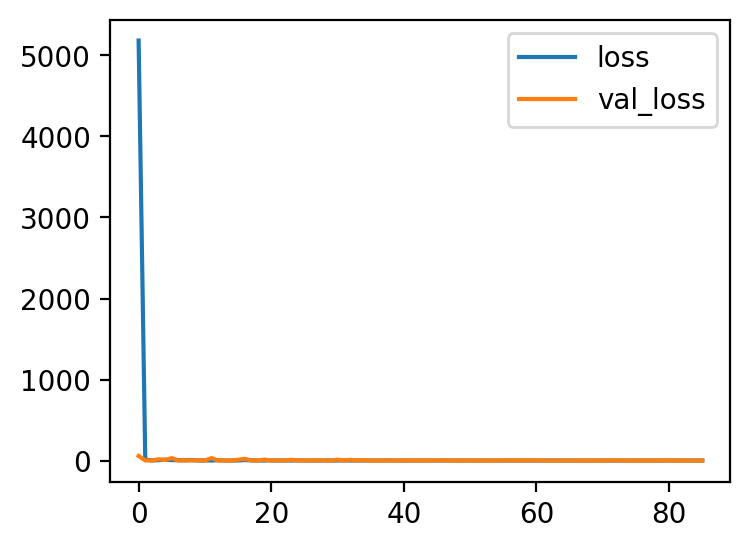

<Figure size 800x600 with 0 Axes>

{'loss': 0.7423848509788513, 'mse': 0.7423848509788513, 'val_loss': 1.2069718837738037, 'val_mse': 1.2069718837738037}
46/46 [==============================] - 1s 31ms/step - loss: 0.7424 - mse: 0.7424 - val_loss: 1.2070 - val_mse: 1.2070
Epoch 87/100
45/46 [============================>.] - ETA: 0s - loss: 0.7448 - mse: 0.7448
Epoch 87: val_loss did not improve from 1.06679


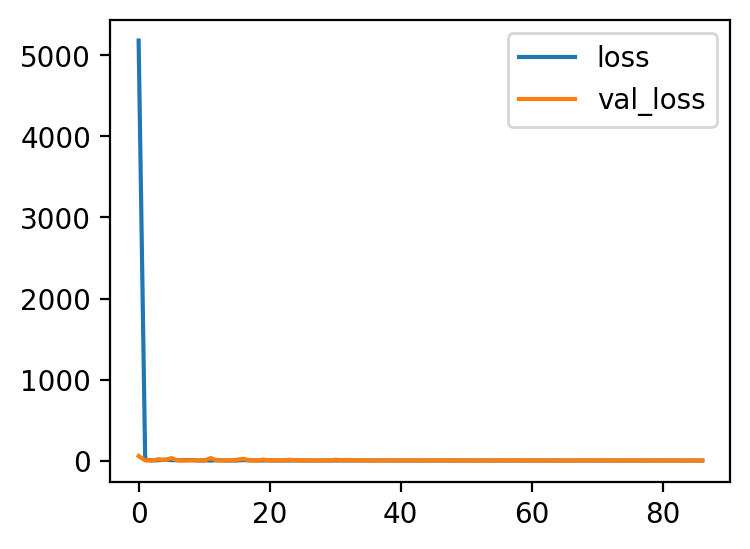

<Figure size 800x600 with 0 Axes>

{'loss': 0.7452000379562378, 'mse': 0.7452000379562378, 'val_loss': 1.286100149154663, 'val_mse': 1.286100149154663}
46/46 [==============================] - 1s 31ms/step - loss: 0.7452 - mse: 0.7452 - val_loss: 1.2861 - val_mse: 1.2861
Epoch 88/100
45/46 [============================>.] - ETA: 0s - loss: 0.9171 - mse: 0.9171
Epoch 88: val_loss did not improve from 1.06679


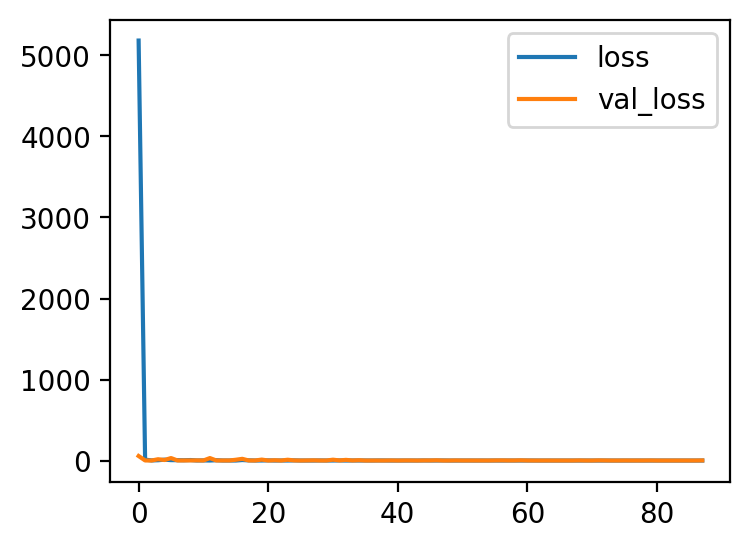

<Figure size 800x600 with 0 Axes>

{'loss': 0.9179181456565857, 'mse': 0.9179181456565857, 'val_loss': 2.4304354190826416, 'val_mse': 2.4304354190826416}
46/46 [==============================] - 1s 31ms/step - loss: 0.9179 - mse: 0.9179 - val_loss: 2.4304 - val_mse: 2.4304
Epoch 89/100
45/46 [============================>.] - ETA: 0s - loss: 0.8542 - mse: 0.8542
Epoch 89: val_loss did not improve from 1.06679


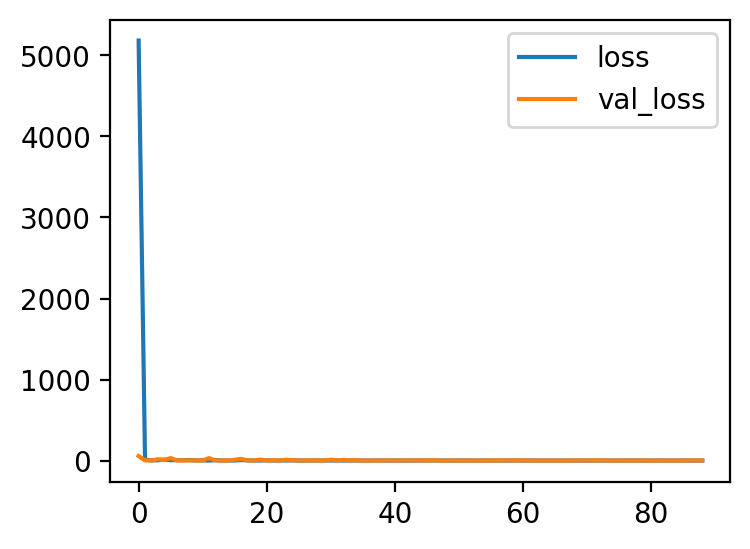

<Figure size 800x600 with 0 Axes>

{'loss': 0.8540812730789185, 'mse': 0.8540812730789185, 'val_loss': 1.2324092388153076, 'val_mse': 1.2324092388153076}
46/46 [==============================] - 1s 31ms/step - loss: 0.8541 - mse: 0.8541 - val_loss: 1.2324 - val_mse: 1.2324
Epoch 90/100
45/46 [============================>.] - ETA: 0s - loss: 0.7959 - mse: 0.7959
Epoch 90: val_loss did not improve from 1.06679


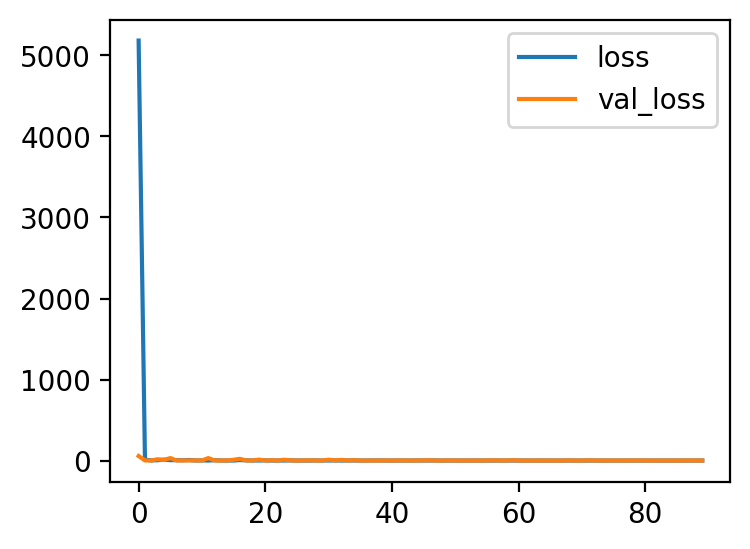

<Figure size 800x600 with 0 Axes>

{'loss': 0.7976738810539246, 'mse': 0.7976738810539246, 'val_loss': 1.2777682542800903, 'val_mse': 1.2777682542800903}
46/46 [==============================] - 1s 31ms/step - loss: 0.7977 - mse: 0.7977 - val_loss: 1.2778 - val_mse: 1.2778
Epoch 91/100
45/46 [============================>.] - ETA: 0s - loss: 0.8490 - mse: 0.8490
Epoch 91: val_loss did not improve from 1.06679


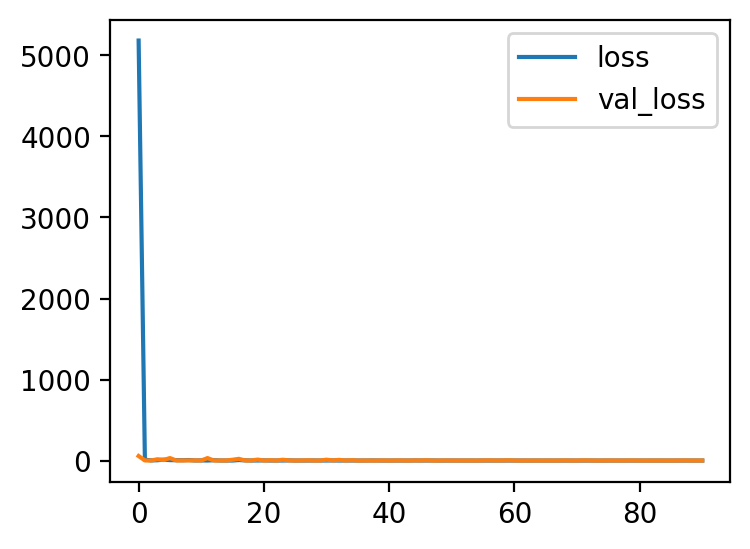

<Figure size 800x600 with 0 Axes>

{'loss': 0.8491350412368774, 'mse': 0.8491350412368774, 'val_loss': 1.4662492275238037, 'val_mse': 1.4662492275238037}
46/46 [==============================] - 1s 31ms/step - loss: 0.8491 - mse: 0.8491 - val_loss: 1.4662 - val_mse: 1.4662
Epoch 92/100
45/46 [============================>.] - ETA: 0s - loss: 0.8079 - mse: 0.8079
Epoch 92: val_loss did not improve from 1.06679


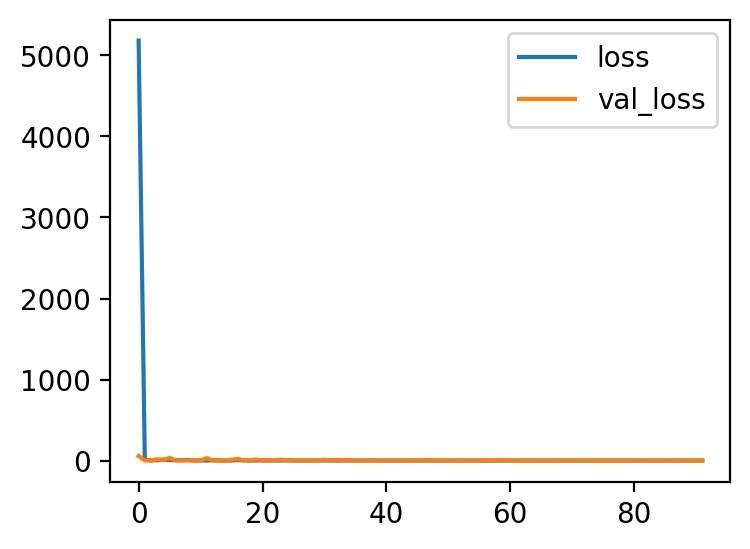

<Figure size 800x600 with 0 Axes>

{'loss': 0.8083555102348328, 'mse': 0.8083555102348328, 'val_loss': 1.5323619842529297, 'val_mse': 1.5323619842529297}
46/46 [==============================] - 1s 31ms/step - loss: 0.8084 - mse: 0.8084 - val_loss: 1.5324 - val_mse: 1.5324
Epoch 93/100
45/46 [============================>.] - ETA: 0s - loss: 0.7539 - mse: 0.7539
Epoch 93: val_loss did not improve from 1.06679


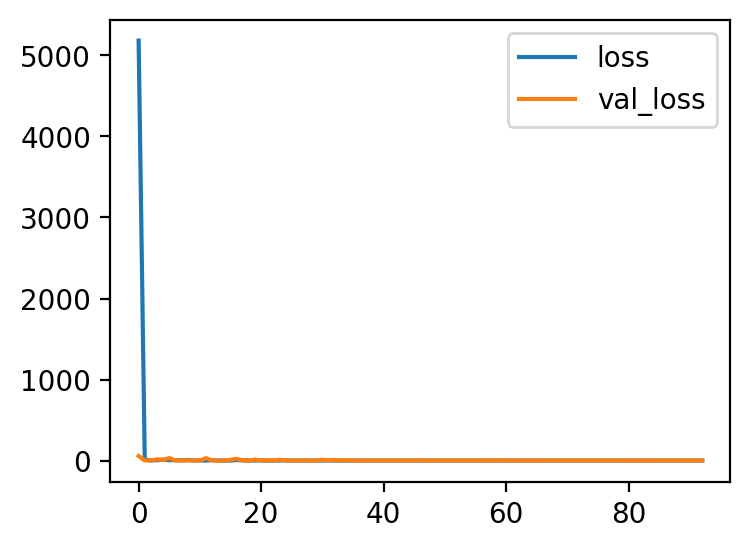

<Figure size 800x600 with 0 Axes>

{'loss': 0.752959668636322, 'mse': 0.752959668636322, 'val_loss': 1.2763381004333496, 'val_mse': 1.2763381004333496}
46/46 [==============================] - 1s 31ms/step - loss: 0.7530 - mse: 0.7530 - val_loss: 1.2763 - val_mse: 1.2763
Epoch 94/100
45/46 [============================>.] - ETA: 0s - loss: 0.8240 - mse: 0.8240
Epoch 94: val_loss did not improve from 1.06679


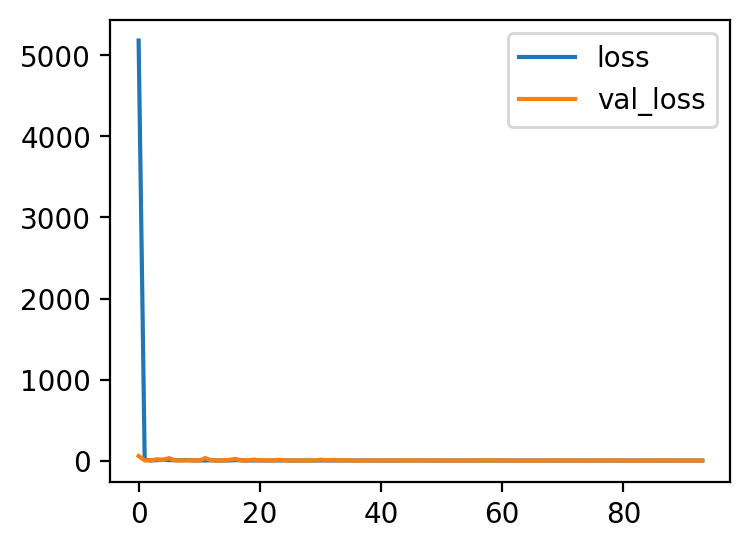

<Figure size 800x600 with 0 Axes>

{'loss': 0.823415994644165, 'mse': 0.823415994644165, 'val_loss': 1.3620712757110596, 'val_mse': 1.3620712757110596}
46/46 [==============================] - 1s 32ms/step - loss: 0.8234 - mse: 0.8234 - val_loss: 1.3621 - val_mse: 1.3621
Epoch 95/100
45/46 [============================>.] - ETA: 0s - loss: 0.7280 - mse: 0.7280
Epoch 95: val_loss did not improve from 1.06679


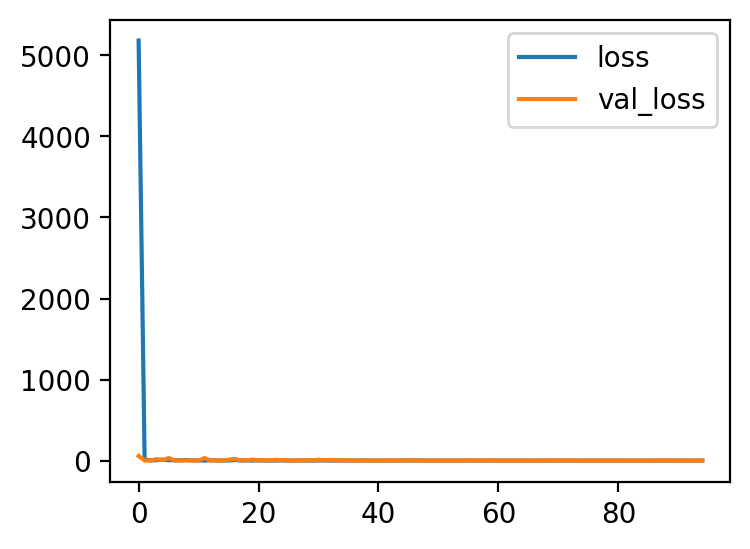

<Figure size 800x600 with 0 Axes>

{'loss': 0.7278214693069458, 'mse': 0.7278214693069458, 'val_loss': 1.6004029512405396, 'val_mse': 1.6004029512405396}
46/46 [==============================] - 1s 32ms/step - loss: 0.7278 - mse: 0.7278 - val_loss: 1.6004 - val_mse: 1.6004
Epoch 96/100
45/46 [============================>.] - ETA: 0s - loss: 0.7867 - mse: 0.7867
Epoch 96: val_loss did not improve from 1.06679


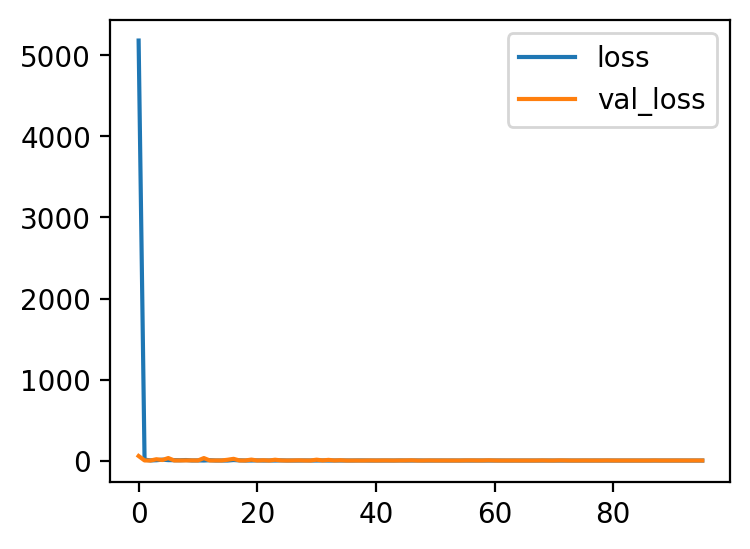

<Figure size 800x600 with 0 Axes>

{'loss': 0.7856173515319824, 'mse': 0.7856173515319824, 'val_loss': 1.334415316581726, 'val_mse': 1.334415316581726}
46/46 [==============================] - 1s 31ms/step - loss: 0.7856 - mse: 0.7856 - val_loss: 1.3344 - val_mse: 1.3344
Epoch 97/100
45/46 [============================>.] - ETA: 0s - loss: 0.7166 - mse: 0.7166
Epoch 97: val_loss did not improve from 1.06679


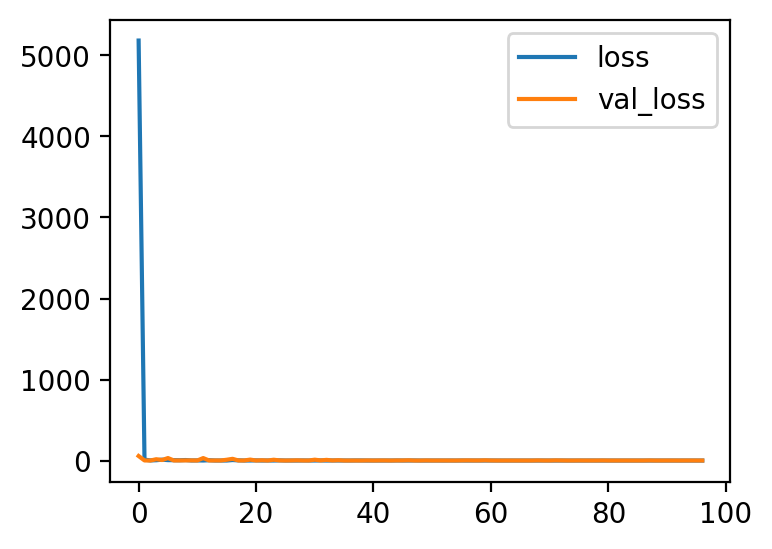

<Figure size 800x600 with 0 Axes>

{'loss': 0.7158776521682739, 'mse': 0.7158776521682739, 'val_loss': 1.276476263999939, 'val_mse': 1.276476263999939}
46/46 [==============================] - 1s 31ms/step - loss: 0.7159 - mse: 0.7159 - val_loss: 1.2765 - val_mse: 1.2765
Epoch 98/100
45/46 [============================>.] - ETA: 0s - loss: 0.7673 - mse: 0.7673
Epoch 98: val_loss did not improve from 1.06679


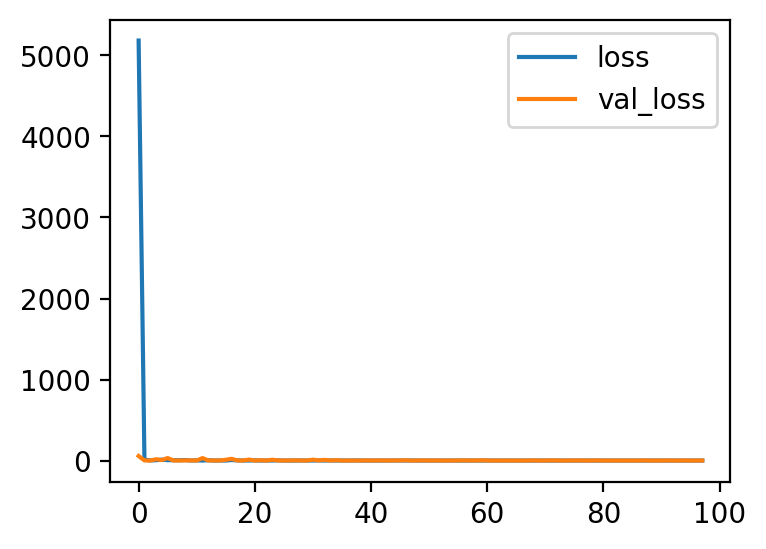

<Figure size 800x600 with 0 Axes>

{'loss': 0.7686628103256226, 'mse': 0.7686628103256226, 'val_loss': 1.5179997682571411, 'val_mse': 1.5179997682571411}
46/46 [==============================] - 1s 31ms/step - loss: 0.7687 - mse: 0.7687 - val_loss: 1.5180 - val_mse: 1.5180
Epoch 99/100
45/46 [============================>.] - ETA: 0s - loss: 1.0363 - mse: 1.0363
Epoch 99: val_loss did not improve from 1.06679


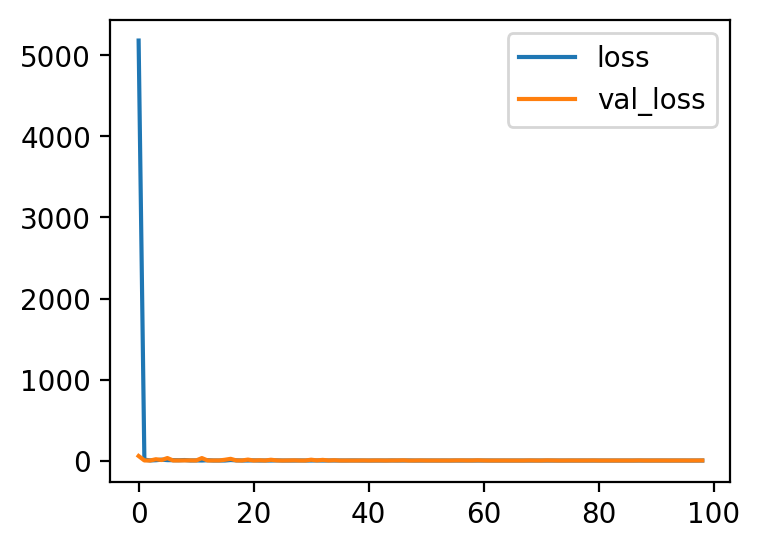

<Figure size 800x600 with 0 Axes>

{'loss': 1.0361515283584595, 'mse': 1.0361515283584595, 'val_loss': 2.0490617752075195, 'val_mse': 2.0490617752075195}
46/46 [==============================] - 1s 32ms/step - loss: 1.0362 - mse: 1.0362 - val_loss: 2.0491 - val_mse: 2.0491
Epoch 100/100
45/46 [============================>.] - ETA: 0s - loss: 0.7884 - mse: 0.7884
Epoch 100: val_loss did not improve from 1.06679


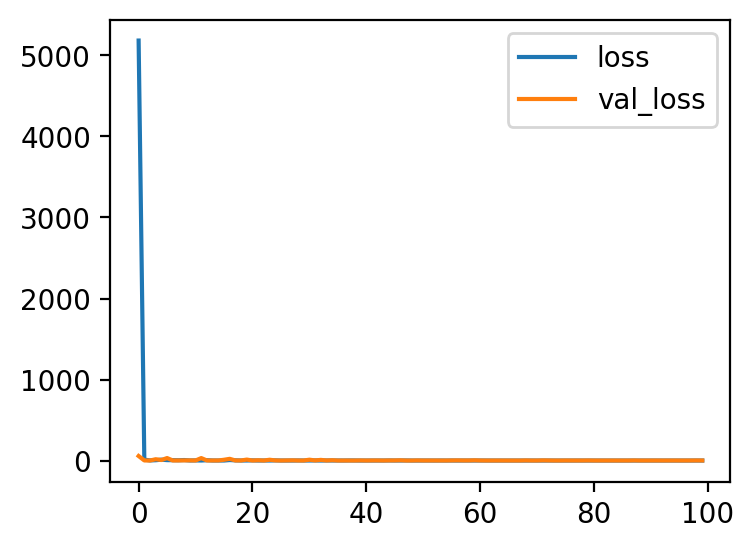

<Figure size 800x600 with 0 Axes>

{'loss': 0.7907288074493408, 'mse': 0.7907288074493408, 'val_loss': 1.5678205490112305, 'val_mse': 1.5678205490112305}
46/46 [==============================] - 2s 34ms/step - loss: 0.7907 - mse: 0.7907 - val_loss: 1.5678 - val_mse: 1.5678


In [16]:
model.fit(train_X, train_Y, validation_data=(valid_X, valid_Y), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1, shuffle=1)
bestEpoch = bestepoch.get_best_epoch()

In [20]:
bestEpoch=48
filepath="models/dscovrmatic-mlp-v1-e%d" % (bestEpoch)
model = load_model(filepath)

In [21]:
test_X = valid_X[[0,25,100,116,73,95,44]]
test_Y = valid_Y[[0,25,100,116,73,95,44]]
y_hat = model.predict(test_X)

1/1 [==============================] - 0s 59ms/step


In [22]:
for i in range(test_Y.shape[0]):
  print('Predicted: %2.2f Truth: %2.2f' %(y_hat[i], test_Y[i]))

Predicted: 2.28 Truth: 2.00
Predicted: 1.58 Truth: 2.00
Predicted: 2.16 Truth: 2.00
Predicted: 3.26 Truth: 3.00
Predicted: 2.43 Truth: 1.00
Predicted: 2.16 Truth: 1.00
Predicted: 2.75 Truth: 1.00


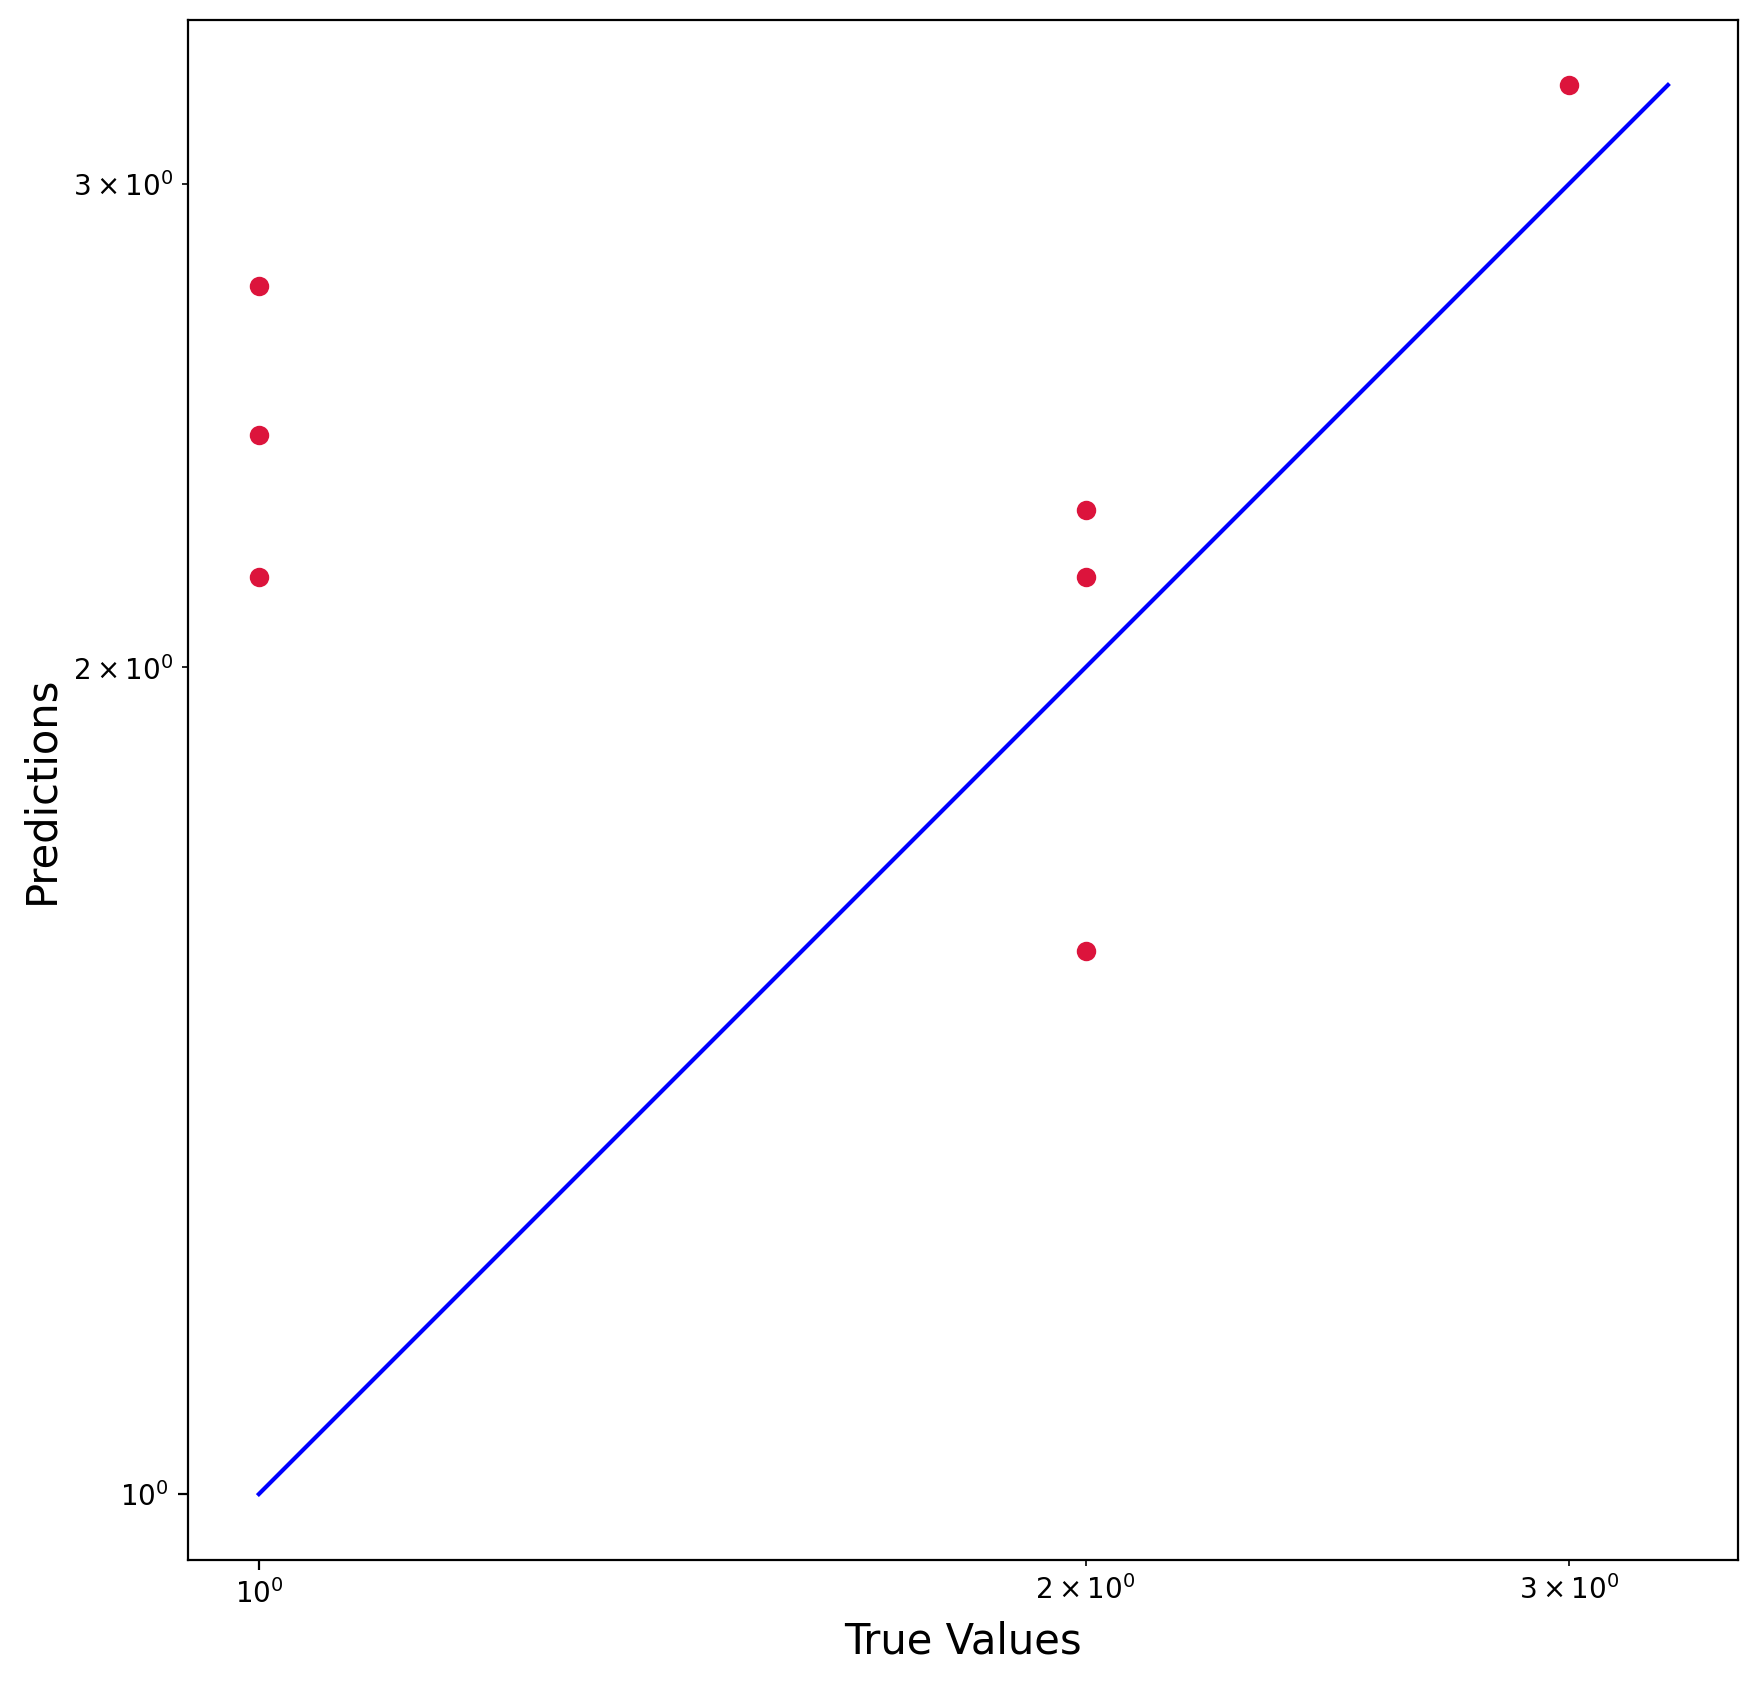

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(test_Y, y_hat, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1=np.max([np.max(y_hat), np.max(test_Y)])
p2=np.min([np.min(y_hat), np.min(test_Y)])
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()